In [1]:
import os
import sys

# print(f"Current Working Directory --> {os.getcwd()}")
#Add one directory above research
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..")) # Get the parent directory
sys.path.append(parent_dir)
current_working_dir = %pwd

print(f"Parent Dir >>> {parent_dir}")
print(f"Current Working Dir >>> {current_working_dir}")

# from configs import cfgs  # Absolute import

Parent Dir >>> C:\Users\maz\dev\Projects_\alzheimer
Current Working Dir >>> C:\Users\maz\dev\Projects_\alzheimer\research


In [2]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

### Imports

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
import pprint
import ipywidgets as widgets
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency
import math

pp = pprint.PrettyPrinter(indent=2)

# Custom Functions
from utils import *

#### Paths

In [4]:
# Create a path object
# dataset_dir = cfgs["DATASET_DIR"]
dataset_dir = "..//dataset//modified"
dataset_path = Path(dataset_dir)
print("Dataset Path")
print("*"*12)
print(f"Dataset: {dataset_path}")
print("\n")

# Find all CSV files inside the directory
files = list(dataset_path.glob("*.csv"))

print("Files in Dataset Dir:")
print("*"*21)
for file_path in files:
    print(file_path.name)  # Print only the file name


# Combining multiple paths
# path_metadata = dataset_path / "MetaData.xlsx"
path_train = dataset_path / "train.csv"
path_test = dataset_path / "test.csv"
path_train_new = dataset_path / "train_without_featEng.csv"
path_train_new_clustered = dataset_path / "train_with_clusters.csv"

print("\n")
print(f"Train File Path --> {path_train}")

Dataset Path
************
Dataset: ..\dataset\modified


Files in Dataset Dir:
*********************
test.csv
test_features.csv
test_labels.csv
train.csv
train_features.csv
train_labels.csv
train_with_clusters.csv


Train File Path --> ..\dataset\modified\train.csv


#### Vars

In [5]:
SPECIFIC_COL_TO_DROP = ['Year']

THRESHOLD_RATIO = 0.1
MAX_UNIQUE = 50

# These are rudundant features
COLS_TO_DROP = ['UID', 'imss_03', 'imss_12', 'issste_03', 'issste_12', 'pem_def_mar_03', 'pem_def_mar_12',
                   'insur_private_03', 'insur_private_12', 'insur_other_03', 'insur_other_12', 'seg_pop_12',
                   'Tired_03', 'Tired_12', 'Happy_03', 'Happy_12']

THRESHOLD_MISSING = 70.0

NUM_STRATEGY = "median"
CAT_STRATEGY = "mode"

THRESHOLD_QUASI_CONSTANT = 0.00000001 # 0.01 (drops -> cols: 23), 0.005 (drops -> cols: 18), 0.00000001

#### Data Loading

##### We will load cleaned file which is saved in notebook `1_eda.ipynb`

In [6]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

In [7]:
try:
    dfTrain = pd.read_csv(path_train, encoding = 'utf8')
    display(dfTrain.head(2))
    print(dfTrain.shape)
except FileNotFoundError:
    print("Error: 'train.csv' not found. Please ensure the file is in the correct location.")
    dfTrain = None

,UID,Year,composite_score,Age_03,Urban_03,Married_03,Marriages_03,Education_03,Num_Living_Child_03,Migration_03,...,Meet_FnF_12,SocialActivities_12,AttendReligiousServices_12,a16a_12,YrsLivedInUSA_12,a22_12,a33b_12,SpeaksEnglish_12,HousingEnvironment_12,PredictionYear
0,aard,2021,104,50-59,Urban,Widowed,1.0,7-9 Years,1 or 2,0.0,...,Once a week,Never,1.0,NaN,NaN,NaN,NaN,0.0,Concrete,9
1,abme,2021,106,50-59,Rural,Married or In Civil Union,1.0,1-5 Years,5 or 6,0.0,...,Never,Never,0.0,NaN,NaN,NaN,NaN,0.0,Concrete,9


(2889, 185)


#### Examine Data

In [8]:
# dfTrain.info(verbose=True, show_counts=True)

In [9]:
# # Get all dtypes as a Series
# all_dtypes = dfTrain.dtypes
# print("\nAll dtypes (Series):")
# print(all_dtypes)
# print("-" * 30)

# # Get unique dtypes
# unique_dtypes = dfTrain.dtypes.unique()
# print("\nUnique dtypes (NumPy array of dtype objects):")
# print(unique_dtypes)
# print("-" * 30)

dtype_summary_result = get_dtype_summary(dfTrain)

# print("*" * 39)
# print("Detailed Dtype Summary (from function):")
# print("*" * 39)
# # pp = pprint.PrettyPrinter(indent=2)
# # pp.pprint(dtype_summary_result)
# # pp.pprint(dtype_summary_result["float64"]["columns"])
# print(f"Data Type 'float64' ==> Total: {len(dtype_summary_result['float64']['columns'])}\n Columns Name: {dtype_summary_result['float64']['columns']}\n")
# print(f"Data Type 'int64' ==> Total: {len(dtype_summary_result['int64']['columns'])}\n Columns Name: {dtype_summary_result['int64']['columns']}\n")
# print(f"Data Type 'object' ==> Total: {len(dtype_summary_result['object']['columns'])}\n Columns Name: {dtype_summary_result['object']['columns']}\n")

In [10]:
# --- Define the Pipeline ---
# Note: The order matters if transformations depend on previous ones,
data_type_conversion = Pipeline([
    ('specific_categorizer', SpecificColumnCategorizer(columns_to_categorize=SPECIFIC_COL_TO_DROP)),
    ('object_to_category', ObjectToCategoryTransformer(threshold_ratio=THRESHOLD_RATIO, max_unique=MAX_UNIQUE)),
    ('float_to_category', FloatToCategoryTransformer()),
    # ('bool_to_category', BooleanToCategoryTransformer())
])

dropColumns = Pipeline([
    ('drop_columns', ColumnDropper(columns_to_drop=COLS_TO_DROP)),
])

dropColumnsHighNA = Pipeline([
    ('drop_columns_high_na', DropColumnsHighNA(threshold=THRESHOLD_MISSING)),
])

missingValueImputer = Pipeline([
    ('missing_value_imputer', MissingValueImputer(num_strategy=NUM_STRATEGY, cat_strategy=CAT_STRATEGY)),
])

identifyAndDropLowVarNum = Pipeline([
    ('identify_and_drop_low_var_num', IdentifyAndDropLowVarNum(quasi_constant_threshold=THRESHOLD_QUASI_CONSTANT)),
])


dataPreprocessing_pipeline = Pipeline([
    ('1_data_type_conversion', data_type_conversion),
    ('2_drop_columns', dropColumns),
    ('3_drop_high_na_columns', dropColumnsHighNA),
    ('4_impute_missing_values', missingValueImputer),
    ('5_identify_and_drop_low_var_num', identifyAndDropLowVarNum),
    # You can add more steps here, e.g., scaling, encoding, etc.
    # ('5_scaling', StandardScaler()), # Example
])

In [11]:
%%capture
print("*" * 48)
print("--- Applying Pipeline | Data Preprocessing ---")
print("*" * 48)
df = dataPreprocessing_pipeline.fit_transform(dfTrain)

In [12]:
print(f"--- PipeLine Completed ---")

--- PipeLine Completed ---


In [13]:
len(df.columns)

160

In [14]:
# # Get all dtypes as a Series
# all_dtypes = df.dtypes
# print("\nAll dtypes (Series):")
# print(all_dtypes)
# print("-" * 30)

# # Get unique dtypes
# unique_dtypes = df.dtypes.unique()
# print("\nUnique dtypes (NumPy array of dtype objects):")
# print(unique_dtypes)
# print("-" * 30)

In [15]:
dtype_summary_result = get_dtype_summary(df)

print("*" * 39)
print("Detailed Dtype Summary (from function):")
print("*" * 39)
# pp = pprint.PrettyPrinter(indent=2)
# pp.pprint(dtype_summary_result)
# pp.pprint(dtype_summary_result["float64"]["columns"])
print(f"Data Type 'float64' ==> Total: {len(dtype_summary_result['float64']['columns'])}\n Columns Name: {dtype_summary_result['float64']['columns']}\n")
print(f"Data Type 'int64' ==> Total: {len(dtype_summary_result['int64']['columns'])}\n Columns Name: {dtype_summary_result['int64']['columns']}\n")
print(f"Data Type 'object' ==> Total: {len(dtype_summary_result['category']['columns'])}\n Columns Name: {dtype_summary_result['category']['columns']}\n")

***************************************
Detailed Dtype Summary (from function):
***************************************
Data Type 'float64' ==> Total: 30
 Columns Name: ['Marriages_03', 'Num_ADL_03', 'Num_IADL_03', 'Num_CES-D_Symptoms_03', 'Num_Illnesses_03', 'Marriages_12', 'Num_ADL_12', 'Num_IADL_12', 'Num_CES-D_Symptoms_12', 'Num_Illnesses_12', 'JobHrsWeekly_03', 'Earnings_03', 'SpouseEarnings_03', 'hincome_03', 'hinc_business_03', 'hinc_rent_03', 'hinc_assets_03', 'hinc_cap_03', 'Pension_03', 'SpousePension_03', 'JobHrsWeekly_12', 'Earnings_12', 'SpouseEarnings_12', 'hincome_12', 'hinc_business_12', 'hinc_rent_12', 'hinc_assets_12', 'hinc_cap_12', 'Pension_12', 'SpousePension_12']

Data Type 'int64' ==> Total: 2
 Columns Name: ['composite_score', 'PredictionYear']

Data Type 'object' ==> Total: 128
 Columns Name: ['Year', 'Age_03', 'Urban_03', 'Married_03', 'Education_03', 'Num_Living_Child_03', 'Migration_03', 'GlobalHealth_03', 'ADL_Dress_03', 'ADL_Walk_03', 'ADL_Bath_03', 'ADL_E

#### Implementing Unsupervised Clustering with K-Means

In [16]:
df_cluster = df.drop(["composite_score", "PredictionYear"], axis=1)
dtype_summary_result = get_dtype_summary(df_cluster)
numeric_features = dtype_summary_result['float64']['columns']
categorical_features = dtype_summary_result['category']['columns']

In [17]:
df_numeric = df_cluster[numeric_features]
df_categorical = df_cluster[categorical_features]

In [18]:
scaler = StandardScaler()

# Use fit_transform on the numeric data ONLY
X_numeric_scaled = scaler.fit_transform(df_numeric)

# Convert the scaled numeric data back to a DataFrame (important for combining later)
df_numeric_processed = pd.DataFrame(X_numeric_scaled, columns=numeric_features, index=df_numeric.index)

In [19]:
cols_numeric = df_numeric_processed.columns.to_list()

print("*" * 29)
print(f"Number of Numeric Columns: {len(cols_numeric)}")
print("*" * 29, "\n")
# print(cols_numeric)

*****************************
Number of Numeric Columns: 30
***************************** 



In [20]:
# --- One-Hot Encode the Categorical Data ---

# pd.get_dummies will convert each category into a new 0/1 column.
df_categorical_processed = pd.get_dummies(df_categorical, drop_first=True)

In [21]:
cols_one_hot_encoded = df_categorical_processed.columns.to_list()

print("*" * 38)
print(f"Number of One Hot Encoded Columns: {len(cols_one_hot_encoded)}")
print("*" * 38, "\n")
# print(cols_one_hot_encoded)

**************************************
Number of One Hot Encoded Columns: 209
************************************** 



In [22]:
# df_categorical_processed["HousingEnvironment_12_Wood, Mosaic, or other Covering"]

In [23]:
# --- Combine the Processed Numeric and Categorical Data ---

# Concatenate the two DataFrames side-by-side
df_processed_for_clustering = pd.concat([df_numeric_processed, df_categorical_processed], axis=1)

print(f"Original number of features: {len(df.columns)}")
print(f"Number of features after processing for clustering: {len(df_processed_for_clustering.columns)}")

Original number of features: 160
Number of features after processing for clustering: 239


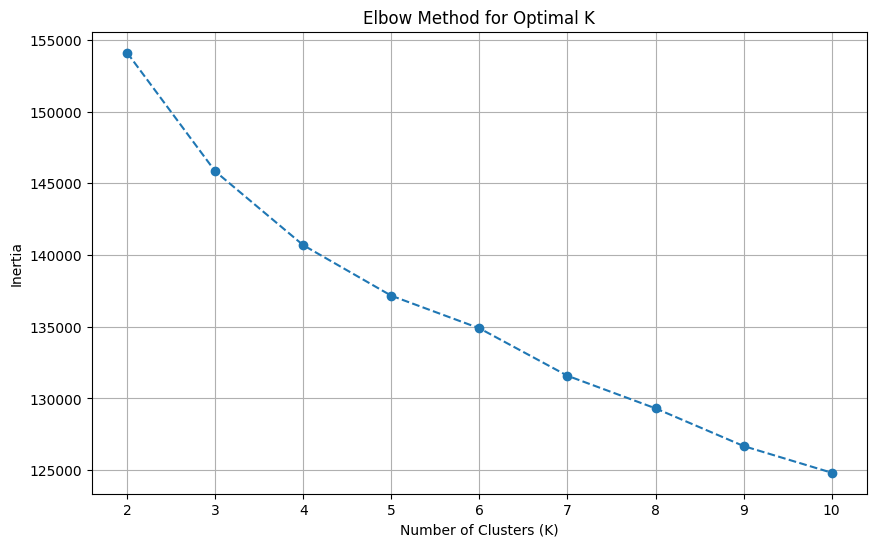

In [24]:
# --- Run K-Means Clustering on the Final DataFrame ---
# Use df_processed_for_clustering to find your optimal K and run K-Means

# --- Run the Elbow Method ---
inertia = []
K_range = range(2, 11)  # Test for K from 2 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_processed_for_clustering)
    inertia.append(kmeans.inertia_)

# --- Plot the Elbow Curve ---
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

### How to Interpret the Elbow Plot:

<hr>

Look for the point where the curve bends, like an elbow. After this point, adding more clusters doesn't significantly reduce the inertia. This "elbow" is your best guess for the optimal number of clusters. Let's assume you find the elbow at K=3 for the next step.

#### (If Elbow Point Not Found-This case) How to Interpret This "Smooth" Curve

The goal is to find the point where adding another cluster stops being worth the added complexity. We are looking for where the rate of descent starts to flatten out.

Let's analyze the candidates:

- From `K=2 to K=3`: A very large drop in inertia. This tells us that going from 2 to 3 clusters significantly improves the model by making the groups much tighter.
- From `K=3 to K=4`: Another large, meaningful drop. The improvement is still very significant.
- From `K=4 to K=5`: The drop is smaller. The curve is starting to flatten. This is the strongest candidate for the "elbow." It's the point where the benefit of adding another cluster starts to noticeably decrease.
- From `K=5` onwards: The line becomes much more linear. The reduction in inertia from adding another cluster (from 5 to 6, 6 to 7, etc.) is roughly constant. This suggests you are no longer finding distinct new groups but are likely just splitting existing clusters into smaller, less meaningful sub-groups.

#### Conclusion and Recommendation

<hr>

While it's not a sharp bend, the most logical and defensible choice for your optimal `K is 4`.

##### Reasoning: K=4 represents the best balance between:

1. Capturing Detail: It explains a good amount of the variance (has a relatively low inertia).
2. Avoiding Overfitting: It stops before the point where you are adding complexity for very little gain.
3. Interpretability: Analyzing 4 groups is typically much more manageable and insightful than trying to find a meaningful story for 6 or 7 groups.

A secondary, also acceptable choice would be K=3 if you want a simpler model with very distinct groups.

Recommend you proceed with `optimal_k = 4`

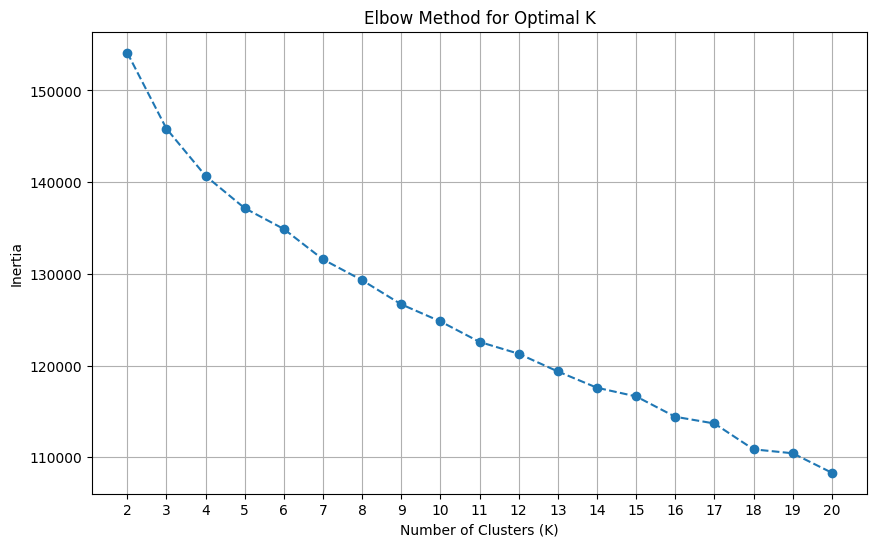

In [25]:
# --- Again Run the Elbow Method with a wider range ---
inertia = []
K_range = range(2, 21)  # Test for K from 2 to 20 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_processed_for_clustering)
    inertia.append(kmeans.inertia_)

# --- Plot the Elbow Curve ---
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

#### Analysis of the New Plot

<hr>

Let's break down the new curve:

- The `Steep Cliff (K=2 to K=6)`: In this region, every new cluster you add causes a large and significant drop in inertia. This is the "high value" zone where the algorithm is finding legitimately distinct groups.
- The `Bend/Elbow Region (K=6 to K=8)`: Look closely at the point for `K=6`. After this point, the slope of the line changes noticeably. The drops from `K=6 to K=7`, and from `K=7 to K=8`, are much smaller than the drops that came before. This is the classic sign of an `elbow` in a real-world dataset.
- The `Long Tail (K=8 onwards)`: From `K=8 to K=19`, the line becomes much flatter and more linear. Adding more clusters in this region provides very little improvement (very small drops in inertia) at the cost of making your model much more complex. This is the "low value" or "overfitting" zone.

#### Conclusion and New Recommendation

Yes, with this new plot, we can make a much more confident recommendation.

The most defensible choice for the optimal number of clusters is K = 6.

#### Reasoning:

- It is at the `knee` of the curve, marking the end of the steepest decline.
- It represents the point where the trade-off between reducing error (inertia) and increasing model complexity is most balanced.
- Going beyond 6 clusters provides significantly less "bang for your buck."
  
#### Why This is Different From the First Plot

This is a perfect illustration of why testing a wider range is important. On the first plot (which only went to `K=10`), `K=4` looked like a reasonable choice. However, by extending the range to `K=20`, we can see the longer-term trend and more accurately pinpoint where the curve truly begins to flatten out, which in this case is around `K=6`.

#### Run K-Means and Analyze the Clusters
##### Now that you have your optimal K, you can run the final clustering and analyze the resulting groups to understand their "phenotype."

In [26]:
# --- Run K-Means with the Optimal K on the Processed Data ---

optimal_k = 6  # <-- Set to the new optimal value based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# CRITICAL: Fit the model on the fully scaled and one-hot encoded data
kmeans.fit(df_processed_for_clustering)

KMeans(n_clusters=6, n_init=10, random_state=42)

In [27]:
# --- Add Cluster Labels Back to Your ORIGINAL DataFrame for Interpretation ---

# The kmeans.labels_ will have the same order as the rows in df_processed_for_clustering.
# As long as the index was maintained, you can assign it directly back.
df['cluster'] = kmeans.labels_

### Analyze Clusters for Numeric Features

<hr>

In [28]:
# --- Analyze the Cluster Profiles ---

# Now, use the ORIGINAL, unscaled data to analyze the clusters. This is crucial
# because it allows you to interpret the profiles in their original units (e.g., dollars, years).
# We'll use the feature lists we defined before the scaling/encoding.
features_for_profiling = numeric_features + categorical_features # Combine original feature lists

# To get meaningful averages for categorical columns, you might need to analyze them differently,
# but for a first look, we can focus on the numeric features and the target variable.
# Let's create a profile focusing on the numeric features and the composite score.
cluster_profiles_numeric = df.groupby('cluster')[numeric_features + ['composite_score']].mean()

print("*" * 53)
print("--- Cluster Profiles (Average values per cluster) ---")
print("*" * 53)
# Transposing the DataFrame (.T) often makes it easier to read when there are many features
# print(cluster_profiles.T)
cluster_profiles_numeric.T

*****************************************************
--- Cluster Profiles (Average values per cluster) ---
*****************************************************


cluster,0,1,2,3,4,5
Marriages_03,1.023006,1.087719,2.098266,0.978937,1.0,0.980861
Num_ADL_03,0.222393,0.017544,0.028902,0.030090,0.0,0.021531
Num_IADL_03,0.134969,0.035088,0.028902,0.018054,0.0,0.007177
Num_CES-D_Symptoms_03,6.179448,2.701754,3.098266,2.814443,9.0,2.270335
Num_Illnesses_03,1.630368,0.929825,0.921965,0.987964,1.0,0.462919
Marriages_12,1.069018,1.052632,2.468208,0.988967,1.0,0.998804
Num_ADL_12,0.661043,0.035088,0.072254,0.080241,0.0,0.058612
Num_IADL_12,0.400307,0.052632,0.040462,0.072217,0.0,0.041866
Num_CES-D_Symptoms_12,6.118098,2.491228,2.976879,2.595787,1.0,2.264354
Num_Illnesses_12,1.588957,1.000000,0.965318,1.045135,0.0,0.588517


In [29]:
# --- Check the Size of Each Cluster ---

print("*" * 20)
print("--- Cluster Sizes ---")
print("*" * 20)

# This tells you how many subjects fall into each group
print(df['cluster'].value_counts().sort_index())

********************
--- Cluster Sizes ---
********************
cluster
0    652
1     57
2    346
3    997
4      1
5    836
Name: count, dtype: int64


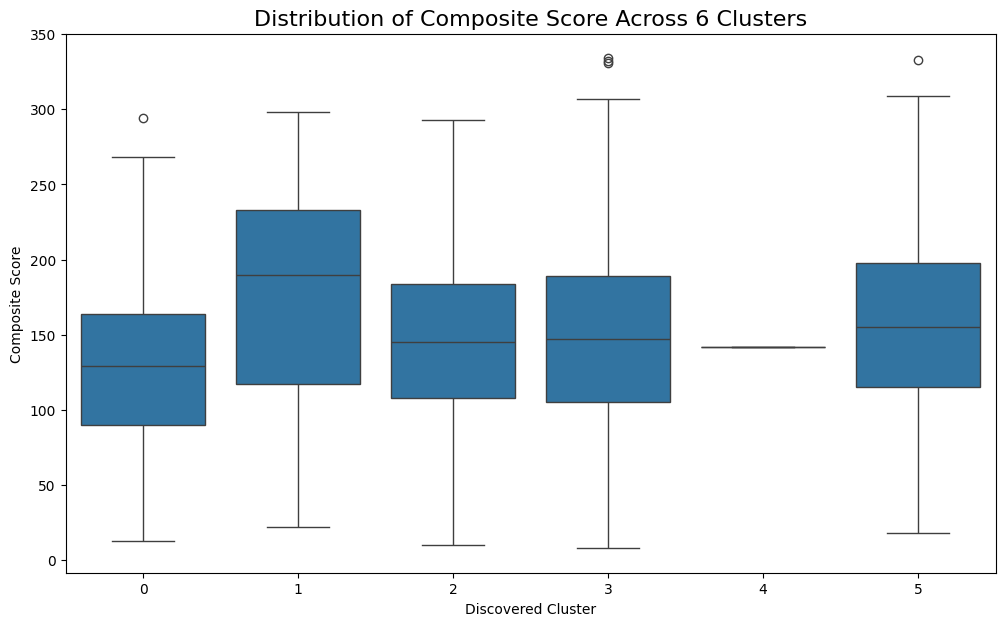

In [30]:
# --- Visualize the Results ---

# This visualization is the most important output.
plt.figure(figsize=(12, 7))
sns.boxplot(x='cluster', y='composite_score', data=df)
plt.title(f'Distribution of Composite Score Across {optimal_k} Clusters', fontsize=16)
plt.xlabel('Discovered Cluster')
plt.ylabel('Composite Score')
plt.show()

## How to Interpret the Boxplot:
<hr>

This plot will clearly show if the hidden groups found have different composite_score distributions. 

If the boxes have very different heights and medians, it confirms that clustering has uncovered meaningful segments in population.

## High-Level Summary from the Boxplot
<hr>

The boxplot is the most important visual. It immediately tells:

1. The clusters are meaningful. The `composite_score` is distributed very differently across the groups. This confirms the clustering was successful.
2. `Cluster 1` is the `highest-performing group`. It has the `highest median` composite_score and its entire "box" (the middle 50% of subjects) is higher than the others.
3. `Cluster 0` is the `lowest-performing group`. It has the `lowest median score`.
4. `Cluster 4` is an `anomaly`. It contains only one person (as confirmed by the Cluster Sizes). This is an outlier and should be treated as a special case or potentially removed from this part of the analysis. It is not a "group."

## Detailed Interpretation: Naming the "Phenotypes"
<hr>
Now, let's use the Cluster Profiles table to understand the story behind each cluster. We'll ignore Cluster 4 since it's just one person.

### Cluster 1: "The Ultra-Wealthy Elite" (N=57)

This is the highest-performing group (composite_score avg: 176). A quick look at the income variables reveals why they are so different.

- `hincome_03`: Average of `~689,000`. This is dramatically higher than any other group.
- `hinc_business_03`, `hinc_cap_03`: Averages of `~548,000` and `~590,000`. This indicates their wealth comes from business and capital, not regular earnings.
- Health: They are relatively healthy with `low Num_Illnesses` and `Num_ADL/IADL` issues.
- Conclusion: This is a small, extremely wealthy group. Their high socioeconomic status is likely a massive protective factor, leading to the highest cognitive scores.

### Cluster 5: "The High-Earning Professionals" (N=836)

This is a large, high-performing group (composite_score avg: 157). They are different from Cluster 1.

- `Earnings_03`: An average of `~31,800`, the highest of any group.
- `Pension_12`: An average of `~27,000`, also the highest.
- `hincome_03` / `hincome_12`: High household income `(~69k / ~80k)`, but driven by earnings and pensions, not the extreme business/capital income of Cluster 1.
- Health: They are the healthiest group overall, with the `lowest Num_Illnesses_03` and `very low ADL/IADL/CES-D symptoms`.
- Conclusion: This group represents successful, working professionals who are aging well. Their strong health and high, steady income contribute to their high scores.

### Cluster 0: "The Frail and Vulnerable" (N=652)

This is your lowest-performing group (composite_score avg: 128). Their profile is defined by poor health indicators.

- `Num_ADL_03` / `Num_ADL_12`: Averages of `0.22 / 0.66`. This is `10-20` times higher than the other large groups. They have significant trouble with basic activities of daily living.
- `Num_IADL_03` / `Num_IADL_12`: Also by far the highest.
- `Num_CES-D_Symptoms_03` / `Num_CES-D_Symptoms_12`: Averages of `~6.1`. This is double the rate of depressive symptoms of other groups.
- `Num_Illnesses_03`: The highest number of chronic illnesses.
- Conclusion: This group is defined by significant physical and mental health challenges. Their frailty and depression are strongly associated with their low composite scores.

### Cluster 2 & 3: "The Middle Cohorts" (N=346 and N=997)

These two large groups represent the "average" individuals in your dataset. Their composite scores are in the middle (~144 and ~147).
- Key Differentiator: The main difference appears to be `socioeconomic`.
      - `Cluster 2` has `higher earnings (Earnings_03: ~11k)` and `pensions (Pension_03: ~6.6k)`.
      - `Cluster 3` has `lower earnings (Earnings_03: ~3.8k)` but `higher spousal income/pension`.
- Health: Both groups are generally `healthy`, with `low ADL/IADL/CES-D` scores, but not quite as robust as `Cluster 5`.
- Conclusion: These are the "middle-class" or "average" aging individuals. They are doing reasonably well, and subtle differences in their income structure and health separate them into two large, similar groups.

<hr>

Furthermore, the best way to identify them is to look for features that show the `largest variation`, or `spread`, across the cluster averages in cluster_profiles_numeric table. We can group them into tiers based on how dramatically they differ between the clusters.

### Tier 1: The "Mega Differentiators"

These are the features that are so dramatically different in one or more clusters that they single-handedly define the group's character. They have an enormous range between the highest and lowest cluster averages.

1. `hincome_03`, `hinc_business_03`, `hinc_cap_03` (and their _12 counterparts):
    - Why: This is the most powerful differentiator. As noted, Cluster 1 ("The Ultra-Wealthy") has an average `hincome_03` of `~689,000`, which is more than `10 times higher` than any other group. This massive gap in income, driven by business and capital, is the primary feature that separates `Cluster 1` from everyone else.
2. `Num_ADL_03 / Num_ADL_12` (Activities of Daily Living):
     - Why: These are the defining features for `lowest-performing group`. Analysis correctly states that `Cluster 0` ("The Frail and Vulnerable") has an `average Num_ADL_12 of 0.66`, which is `10-20 times higher` than the other large groups (e.g., Cluster 5's is 0.05). This massive difference in physical impairment is a core reason Cluster 0 is distinct.
3. `Num_IADL_03 / Num_IADL_12` (Instrumental Activities of Daily Living):
    - Why: Same story as `Num_ADL`. `Cluster 0` stands alone with by far the highest average number of issues with tasks like managing money or shopping.
`Num_CES-D_Symptoms_03 / Num_CES-D_Symptoms_12` (Depressive Symptoms):
    - Why: A primary `mental health differentiator`. `Cluster 0's` average of `~6.1` is roughly double that of all other major clusters, clearly marking it as the group with the most significant mental health challenges.
   
### Tier 2: Strong Differentiators

These features show very clear and significant differences between clusters, even if not on the same massive scale as Tier 1. They are crucial for distinguishing between the `higher-performing` and `middle-tier` groups.
1. `Earnings_03 / Earnings_12`:
    - Why: This is the key feature that defines `Cluster 5` ("High-Earning Professionals"). Their average `Earnings_03` of `~31,800` is nearly `three times higher` than the next closest group (`Cluster 2` at `~11,200`) and far above the others. It tells a different story of wealth generation than the capital-based wealth of `Cluster 1`.
2. `Pension_12`:
    - Why: Another strong marker for `Cluster 5`, whose average pension of `~27,000` is significantly `higher` than all `other groups`, reinforcing their profile as successful, well-prepared professionals.
3. `Num_Illnesses_03`:
    - Why: A clear general `health` marker. It effectively distinguishes between the `most` and `least healthy groups`. `Cluster 0` has the `highest average (1.63)`, while `Cluster 5 has the lowest (0.46)`. This range is very telling.
  
### Tier 3: Middle Cohort Differentiators
This tier highlights the more subtle but equally important `socioeconomic features` that distinguish the `two largest`, most "average" groups in the dataset: `Cluster 2` and `Cluster 3`. While not defined by the dramatic extremes of `Tier 1` and `Tier 2`, these features are the key to understanding the nuanced differences within the representative majority of population.
1. `SpouseEarnings_03, SpousePension_03`:
    - Why: These features tell a story about the structure of `household income`, not just its `total amount`. While both clusters represent financially stable, middle-class individuals, this is the main factor that separates them.
    - `Cluster 2's` financial profile is driven more by their own higher `Earnings_03 (~11k)` and `Pension_03 (~6.6k)`.
    - In contrast, `Cluster 3` has much `lower personal earnings (~3.8k)` but compensates with significantly `higher average spousal contributions`, particularly `SpouseEarnings_03 (~15k)`.
    - This distinction reveals two different "middle-class" archetypes: one based on stronger individual earning power `(Cluster 2)` and another based on a `household's combined or spousal-driven income (Cluster 3)`. This is a crucial, real-world insight that a simple correlation analysis would completely miss.
   
### Summary Table: Distinguishing Numerical Features

Here is a summary of the most distinguishing numeric features:

| Rank | Tier | Feature(s) | Reason for Importance | Key Distinguishing Cluster(s) |
| :--- | :--- | :--- | :--- | :--- |
| **1** | **Tier 1** | `hincome_03`, `hinc_business_03`, `hinc_cap_03` | **Orders of magnitude difference** in income from business/capital. | **Cluster 1** (Ultra-Wealthy) |
| **2** | **Tier 1** | `Num_ADL_12`, `Num_IADL_12` | **10-20x difference** in physical impairment levels. | **Cluster 0** (Frail & Vulnerable) |
| **3** | **Tier 1** | `Num_CES-D_Symptoms_12` | **~2x difference** in depressive symptoms, indicating mental health status. | **Cluster 0** (Frail & Vulnerable) |
| **4** | **Tier 2** | `Earnings_03` / `Earnings_12` | **~3x difference** in income from employment. | **Cluster 5** (High-Earning Professionals) |
| **5** | **Tier 2** | `Num_Illnesses_03` | **~3.5x difference** in the number of chronic illnesses reported. | **Cluster 0** (highest) vs. **Cluster 5** (lowest) |
| **6** | **Tier 2** | `Pension_12` | **Significant difference** in retirement income. | **Cluster 5** (highest) |
| **7** | **Tier 3** | `SpouseEarnings_03`, `SpousePension_03` | **Subtle but key socioeconomic differences** that separate the two largest 'middle' groups. Distinguishes between personal vs. spousal income sources. | **Cluster 2** (higher personal income) vs. **Cluster 3** (higher spousal income) |

### Analyze Clusters for Categorical Features

<hr>

This is where you will add the rich, descriptive context to your personas.

- Step A: Find the Key Differentiators: We will run the `Chi-Squared test` on all `128 categorical features` against the cluster labels. This is a global step—you do it once on the whole dataset to find which categorical features are best at telling the clusters apart.

- Step B: Create the High-Level Persona Table: Using the `top ~15 features` identified in `Step A`, we will create the `mode() table (df.groupby('cluster')[top_features].agg(lambda x: x.mode()...))`. This gives us the most common categorical traits for each cluster (e.g., "Cluster 0's most common health status is 'Fair'," "Cluster 5's is 'Good'").

- Step C: Visualize with `Heatmaps`: For the `absolute top 3-5 differentiators`, we will create the `crosstab()` proportion heatmaps to visualize these key differences beautifully.

In [31]:
# --- Prerequisites ---
# Ensure, having a DataFrame named 'df' that contains:
# 1. original, human-readable data (not scaled or encoded).
# 2. The 'cluster' column added from the K-Means results.

# Let's filter out the outlier cluster (cluster 4) for this analysis
df_analysis = df[df['cluster'] != 4].copy()

# --- Step 1: Find the Key Differentiating Features (Chi-Squared Test) ---

print("************************************************************")
print("--- Step 1: Finding Top Differentiating Features... ---")
print("************************************************************")

# Automatically get the names of all categorical columns
# all_categorical_features = df_analysis.select_dtypes(include='object').columns.tolist()
categorical_features
Top_N_Features = 15
chi2_results = []

# Loop through each feature to test its association with the cluster labels
for feature in categorical_features:
    # Create a contingency table (frequency count) of the feature vs. the cluster
    contingency_table = pd.crosstab(df_analysis['cluster'], df_analysis[feature])
    
    # Perform the Chi-Squared test
    # It returns the statistic, p-value, degrees of freedom, and expected frequencies
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    chi2_results.append({'feature': feature, 'chi2_statistic': chi2, 'p_value': p})

# Convert results to a DataFrame and sort to find the most significant features
chi2_df = pd.DataFrame(chi2_results)
chi2_df = chi2_df.sort_values(by='chi2_statistic', ascending=False)

# This is the list of the most important features for storytelling
top_differentiating_features = chi2_df.head(Top_N_Features)['feature'].tolist()

print(f"\n--- Top {Top_N_Features} Most Distinguishing Categorical Features Found ---")
print(top_differentiating_features)

************************************************************
--- Step 1: Finding Top Differentiating Features... ---
************************************************************

--- Top 15 Most Distinguishing Categorical Features Found ---
['Gender', 'SpouseGender_03', 'SpouseGender_12', 'CES-D_Symptoms_12', 'Employment_12', 'Employment_03', 'CES-D_Symptoms_03', 'Depressed_12', 'Depressed_03', 'JobCatLongest_12', 'Sad_12', 'Sad_03', 'Lonely_12', 'Hard_03', 'Hard_12']


In [32]:
# --- Step 2: Create a High-Level "Persona" Table (The Mode) ---

print("\n\n********************************************************")
print("--- Step 2: High-Level Cluster Personas (Summary) ---")
print("********************************************************")

# This table shows the MOST COMMON category for each top feature within each cluster
persona_df = df_analysis.groupby('cluster')[top_differentiating_features].agg(lambda x: x.mode().iloc[0])

# Transpose (.T) for much better readability
# print(persona_df.T)
persona_df.T



********************************************************
--- Step 2: High-Level Cluster Personas (Summary) ---
********************************************************


cluster,0,1,2,3,5
Gender,Woman,Woman,Woman,Woman,Man
SpouseGender_03,Man,Man,Man,Man,Woman
SpouseGender_12,Man,Man,Man,Man,Woman
CES-D_Symptoms_12,1.0,0.0,0.0,0.0,0.0
Employment_12,Dedicated to Household Chores,Currently Working,Currently Working,Dedicated to Household Chores,Currently Working
Employment_03,Dedicated to Household Chores,Currently Working,Currently Working,Dedicated to Household Chores,Currently Working
CES-D_Symptoms_03,1.0,0.0,0.0,0.0,0.0
Depressed_12,1.0,0.0,0.0,0.0,0.0
Depressed_03,1.0,0.0,0.0,0.0,0.0
JobCatLongest_12,"Artisans and Workers in Production, Repair, Ma...","Artisans and Workers in Production, Repair, Ma...","Artisans and Workers in Production, Repair, Ma...","Artisans and Workers in Production, Repair, Ma...","Artisans and Workers in Production, Repair, Ma..."


## Interpreting the Categorical Profiles

The results are remarkably clear and powerful. The analysis reveals that the clusters are not just separated by numbers (like income and health counts), but also by fundamental demographic and psychological characteristics.

The most distinguishing features fall into two dominant themes: Mental/Emotional Health and Demographics/Lifestyle (Gender & Employment).

## Tier 1: Mega Differentiators

These are the features that create a near-perfect, black-and-white separation between one cluster and the rest.

1. Mental & Emotional Health Indicators (`CES-D_Symptoms`, `Depressed`, `Sad`, `Lonely`, `Hard`):
    - Why: This is the most powerful finding in the categorical data. For `Cluster 0` ("The Frail and Vulnerable"), the most common response (mode) to every single one of these negative emotional state questions is `1.0 (Yes)`. For all other `clusters (1, 2, 3, and 5)`, the mode is` 0.0 (No)`.
    - This isn't just a subtle difference; it's a defining chasm. It provides the `psychological backstory` to the `numeric findings`. We now know that `Cluster 0's` poor physical health is accompanied by significant, self-reported emotional and mental distress, completing its "vulnerable" persona.
2. Gender (`Gender`, `SpouseGender_03`, `SpouseGender_12`):
    - Why: This reveals a fundamental demographic split. `Cluster 5` ("The High-Earning Professionals") is the only group where the most common gender is `"Man."` All other major `clusters (0, 1, 2, and 3)` are predominantly `"Woman."`
    - This is a key insight that strongly aligns with the `numeric profile of Cluster 5`. This group is defined by `high personal earnings` and `pensions`, and this analysis shows it is also primarily a `male cohort`.

## Tier 2: Strong Differentiators

This feature provides a clear split that helps to define the lifestyle and socioeconomic context of the clusters.
1. Employment Status (`Employment_03`, `Employment_12`):
    - Why: This cleanly divides the clusters into two distinct lifestyle groups.
    - The `high-performing groups—Clusters 1, 2`, and `5`—are all predominantly "Currently Working."
    - In contrast, the `lowest-performing group (Cluster 0)` and one of the `middle cohorts (Cluster 3)` are predominantly "Dedicated to Household Chores."
    - This adds another critical layer to our understanding. It reinforces the vulnerability of `Cluster 0` `(poor health and not working)` and provides a key differentiator between the two `"Middle Cohorts"` `(Cluster 2 is primarily working, while Cluster 3 is not)`.

A Note on `JobCatLongest_12`: While this feature had a `high Chi-Squared score` (meaning there is a `statistical association`), the most common job category was the same for all clusters. This means the differences are in the less common categories, so it's not a good feature for a high-level "persona" summary, but would be interesting to explore with a heatmap.

Based on the summary table provided `(persona_df)`, there is no clear `Tier 3` for the `categorical features`.

Here’s the simple reason why:

The top differentiating categorical features (`Gender, Employment, and the mental health indicators`) are so powerful that they create very clean, `high-level splits` between the `clusters`. They tend to divide the groups into `two major camps (e.g., "Working" vs. "Not Working," "Man" vs. "Woman," "Distressed" vs. "Not Distressed")`.

The feature that should have been the `Tier 3` differentiator—the one that explains the subtle difference between `Cluster 2 and Cluster 3`—is `Employment_12`.

Let's look at what the `persona_df` shows:

- Cluster 2's mode is "Currently Working."
- Cluster 3's mode is "Dedicated to Household Chores."

This is not a subtle difference; it's a very strong one. That's why I classified `Employment_12` as a `Tier 2`: Strong Differentiator. It's a key feature that helps separate the middle cohorts, but it does so in a very clear and distinct way, not a subtle one.

## The Key Takeaway
The "story" of clusters is built differently by the two types of features:
1. Numeric Features: The difference between the `two middle cohorts (2 and 3)` was subtle, found in the nuanced details of whose income `(personal vs. spousal)` was higher. This created the need for a Tier 3.
2. Categorical Features: The difference between the `two middle cohorts` is actually very clear and `strong—it's their working status`. This is a Tier 2 level differentiator.
Therefore, the categorical summary table is correct as is. It accurately reflects that the most powerful categorical variables create strong, high-contrast divisions between the groups, leaving no need for a "subtle" Tier 3.

## Summary Table: Distinguishing Categorical Features

| Rank | Tier | Feature(s) | Reason for Importance | Key Distinguishing Cluster(s) |
| :--- | :--- | :--- | :--- | :--- |
| **1** | **Tier 1: Mega Differentiators** | `Depressed`, `Sad`, `Lonely`, `Hard`, `CES-D_Symptoms` | **Unanimous "Yes" vs. "No" split** on all negative emotional state indicators. | **Cluster 0** (the only group with "Yes" as the most common answer) |
| **2** | **(Tier 1)** | `Gender`, `SpouseGender` | **Clear, fundamental demographic split.** | **Cluster 5** (the only predominantly "Man" group) |
| **3** | **Tier 2: Strong Differentiators** | `Employment_03`, `Employment_12` | **Cleanly separates clusters by working status**, a key lifestyle and socioeconomic indicator. | **Clusters 1, 2, 5** ("Working") vs. **Clusters 0, 3** ("Household Chores") |

In [33]:
# # --- Step 3: Visualize the Key Differences (Heatmaps) ---

# print("\n\n**************************************************************")
# print(f"--- Step 3: Visualizing Top {Top_N_Features} Differentiators... ---")
# print("**************************************************************")

# # Let's visualize the top {Top_N_Features} features from Chi-Squared test
# # for feature in top_differentiating_features[:3]:

# num_features = len(top_differentiating_features)

# # Check if the number of features is even or odd to set the number of columns
# if num_features % 2 == 0:
#     ncols = 2
# else:
#     ncols = 3

# # Calculate the number of rows needed using ceiling division
# nrows = math.ceil(num_features / ncols)

# # Create a figure that's sized appropriately for the grid
# # We make it wider for more columns and taller for more rows
# fig, axes = plt.subplots(
#     nrows=nrows, 
#     ncols=ncols, 
#     figsize=(ncols * 7, nrows * 5) # Dynamic sizing
# )

# # Flatten the axes array to make it easy to loop through, even if it's just one row
# flat_axes = axes.flatten()

# # Loop through both the features and the corresponding axis object
# for feature, ax in zip(top_differentiating_features, flat_axes):
#     # Create the proportion table (same as before)
#     proportion_df = pd.crosstab(index=df_analysis['cluster'], columns=df_analysis[feature], normalize='index')
#     # Create the heatmap on the specific axis 'ax'
#     sns.heatmap(
#         proportion_df, 
#         annot=True,
#         cmap="YlGnBu",
#         fmt=".1%",
#         ax=ax
#     )
#     # Set the title and labels for the individual subplot
#     ax.set_title(f'Distribution of "{feature}"', fontsize=14)
#     ax.set_ylabel('Cluster')
#     ax.set_xlabel('') # Keep the x-axis label clean

#     # Rotate the x-axis labels for better readability
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# # If we have an odd number of plots in an even grid, some axes will be empty.
# # This loop turns them off to keep the figure clean.
# for i in range(num_features, len(flat_axes)):
#     flat_axes[i].axis('off')

# # Add a main title for the entire figure
# # Add a main title for the entire figure
# fig.suptitle('Proportional Distribution of Top Features Across Clusters', fontsize=20, y=0.95) # Adjust y to give it space
# # Use subplots_adjust for more control over spacing instead of tight_layout
# fig.subplots_adjust(
#     top=0.90,
#     hspace=0.6,  # <-- Increase this value to add more vertical space
#     wspace=0.2   # You can adjust this for horizontal space if needed
# )
# plt.show()



******************************************************
--- Step 3: Visualizing Top 15 Differentiators... ---
******************************************************


**********************************************
--- Visualizing first 9 Differentiators... ---
**********************************************


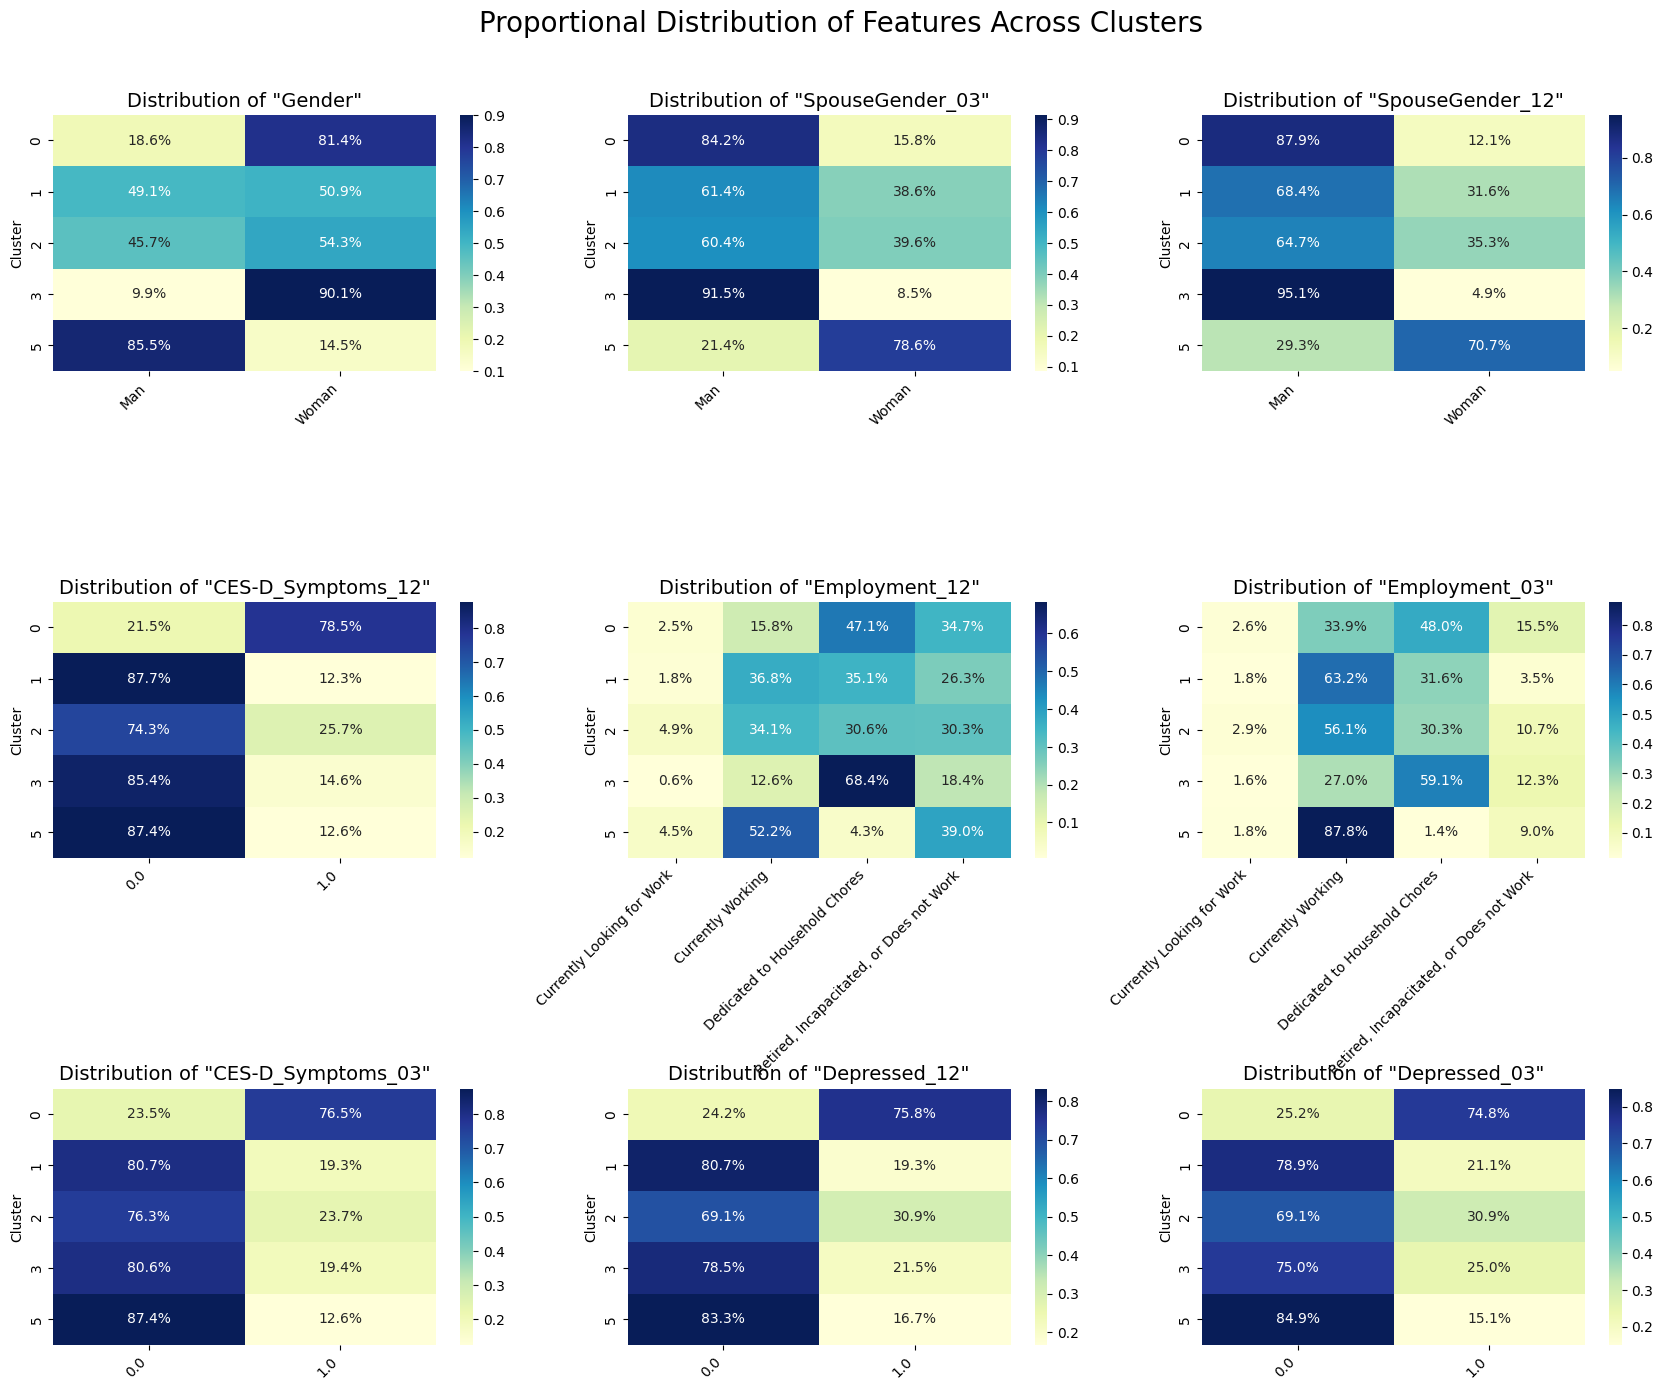

In [34]:
print("\n\n******************************************************")
print(f"--- Step 3: Visualizing Top {Top_N_Features} Differentiators... ---")
print("******************************************************")

differentiating_features = top_differentiating_features[:9]

num_features = len(differentiating_features)

print("\n\n**********************************************")
print(f"--- Visualizing first {num_features} Differentiators... ---")
print("**********************************************")

# Check if the number of features is even or odd to set the number of columns
if num_features % 2 == 0:
    ncols = 2
else:
    ncols = 3

# Calculate the number of rows needed using ceiling division
nrows = math.ceil(num_features / ncols)

# Create a figure that's sized appropriately for the grid
# We make it wider for more columns and taller for more rows
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols * 7, nrows * 5) # Dynamic sizing
)

# Flatten the axes array to make it easy to loop through, even if it's just one row
flat_axes = axes.flatten()

# Loop through both the features and the corresponding axis object
for feature, ax in zip(differentiating_features, flat_axes):
    # Create the proportion table (same as before)
    proportion_df = pd.crosstab(index=df_analysis['cluster'], columns=df_analysis[feature], normalize='index')
    # Create the heatmap on the specific axis 'ax'
    sns.heatmap(
        proportion_df, 
        annot=True,
        cmap="YlGnBu",
        fmt=".1%",
        ax=ax
    )
    # Set the title and labels for the individual subplot
    ax.set_title(f'Distribution of "{feature}"', fontsize=14)
    ax.set_ylabel('Cluster')
    ax.set_xlabel('') # Keep the x-axis label clean

    # Rotate the x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# If we have an odd number of plots in an even grid, some axes will be empty.
# This loop turns them off to keep the figure clean.
for i in range(num_features, len(flat_axes)):
    flat_axes[i].axis('off')

# Add a main title for the entire figure
# Add a main title for the entire figure
fig.suptitle('Proportional Distribution of Features Across Clusters', fontsize=20, y=1.0) # Adjust y to give it space
# Use subplots_adjust for more control over spacing instead of tight_layout
fig.subplots_adjust(
    top=0.93,
    hspace=0.9,  # <-- Increase this value to add more vertical space
    wspace=0.2   # You can adjust this for horizontal space if needed
)
plt.show()

### First Row | Key Insights from the Heatmaps
<hr>

1. Strong `Gender` Divide: The plots reveal a powerful separation between the clusters based on gender.
    - `Cluster 5` is predominantly `male (85.5%)` and therefore has a spouse who is predominantly `female (78.6% in '03, 70.7% in '12)`. This aligns perfectly with its `"High-Earning Professionals"` persona.
    - `Clusters 0 and 3` are overwhelmingly `female (81.4% and 90.1%)` with predominantly male spouses. This aligns with their personas as `"Frail & Vulnerable"` and a non-working `"Middle Cohort."`
2. `Clusters 1 and 2` are More Balanced: These two clusters `("The Ultra-Wealthy" and the working "Middle Cohort")` have a much more even gender split, closer to `50/50`.
3. Consistent Story: The `Gender, SpouseGender_03, and SpouseGender_12` plots all tell the same consistent story, reinforcing that `gender` is a fundamental and stable characteristic that strongly defines the personas of these hidden groups.

### Second Row | Key Insights from the Heatmaps
<hr>

1. `Mental Health` is a Defining Feature: The `CES-D_Symptoms_1`2 plot is the most dramatic. It perfectly isolates `Cluster 0 ("The Frail & Vulnerable")` as the only group with a very high rate of self-reported depressive symptoms `(78.5%)`. All other clusters are the opposite, with the vast majority reporting no significant symptoms.
2. A Clear `"Working"` vs. `"Non-Working"` Divide: The employment plots reveal a major lifestyle split.
    - `Clusters 1, 2, and 5` are the `"working"` groups, with `"Currently Working"` being a dominant category for all three. This is especially true for `Cluster 5`, where over `52%` are currently working in the `'12 period`.
    - `Clusters 0 and 3` are the `"non-working"` groups. They are both dominated by individuals who are `"Dedicated to Household Chores."`
3. Employment Status is a Stable Trait: The patterns are very consistent between `Employment_03 and Employment_12`, showing that these employment characteristics are stable, long-term attributes that help define the personas of each cluster.

### Third Row | Key Insights from the Heatmaps
<hr>

1. Overwhelming Confirmation of `Mental Health` as a Differentiator: All three plots tell the exact same, powerful story. `Cluster 0 ("The Frail & Vulnerable")` is in a league of its own, with approximately `75%` of its members reporting symptoms of `depression` in both the `'03 and '12 periods`.
2. Psychological Resilience in Other Clusters: In stark contrast, all other `clusters (1, 2, 3, and 5)` show high `psychological resilience`, with the vast majority of their members `(~70% to 87%)` reporting no symptoms of depression.
3. A Stable, Chronic Issue: The fact that the pattern is nearly identical for` Depressed_03` and `Depressed_12` indicates that for `Cluster 0`, this is a stable, chronic issue rather than a temporary state. This is a core, defining feature of this vulnerable group.



****************************************************************
--- Visualizing next 1 Differentiator: `JobCatLongest_12`... ---
****************************************************************


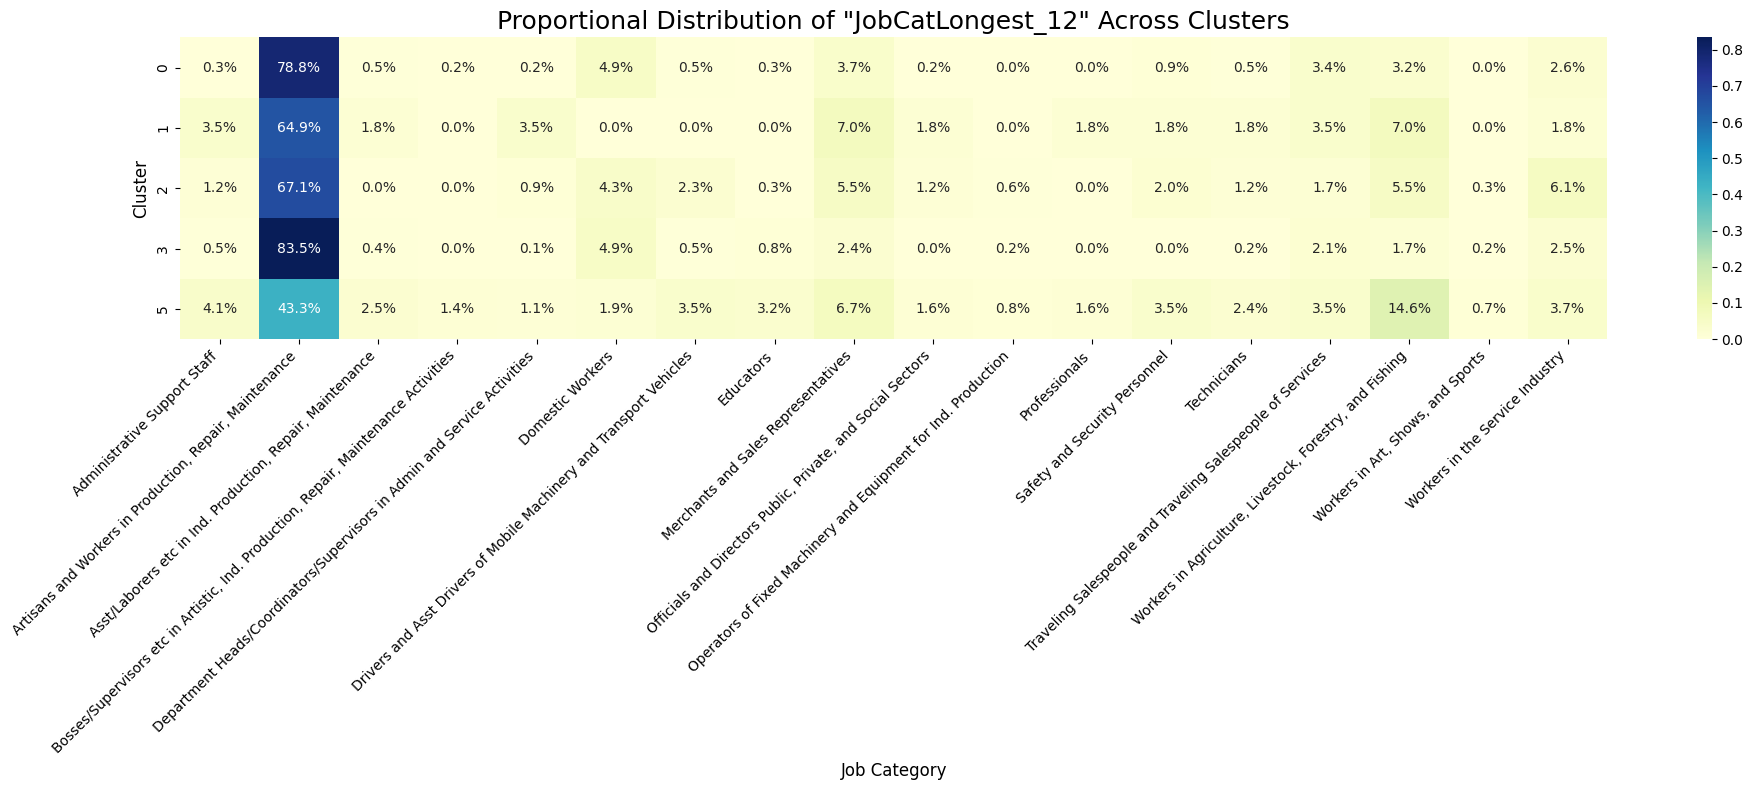

In [35]:
differentiating_features = top_differentiating_features[9:10]
num_features = len(differentiating_features)
feature_to_plot = 'JobCatLongest_12' 

print("\n\n****************************************************************")
print(f"--- Visualizing next {num_features} Differentiator: `{feature_to_plot}`... ---")
print("****************************************************************")

proportion_df = pd.crosstab(
    index=df_analysis['cluster'], 
    columns=df_analysis[feature_to_plot], 
    normalize='index'
)

fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(
    proportion_df, 
    annot=True,
    cmap="YlGnBu",
    fmt=".1%",
    ax=ax  # Plot directly onto our single axis
)

ax.set_title(f'Proportional Distribution of "{feature_to_plot}" Across Clusters', fontsize=18)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_xlabel('Job Category', fontsize=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Why the Plot Looks So "Weird"
<hr>

The plot looks this way for one simple reason: the distribution of jobs is heavily skewed. One single job category is overwhelmingly dominant for almost every group, which makes all the other categories look tiny and insignificant by comparison.

#### The Dominant Pattern: The "Artisan & Worker" Background

The most striking feature is the dark blue vertical band under the category `"Artisans and Workers in Production, Repair, Maintenance."`
    - For `Clusters 0, 1, 2, and 3`, this s`ingle job category` represents the background of the vast majority of people, ranging from `~65% to a massive 83.5%`.
    - What this means: These four groups, despite their different `health` and `wealth` outcomes, share a common `socioeconomic` background heavily rooted in skilled trades, production, or manual labor. This is the `"baseline"` career for most people in the dataset.

#### The Dramatic Exception: Cluster 5

Now, look at the row for `Cluster 5` `("The High-Earning Professionals")`. This is where the story gets interesting.
    - It Breaks the Pattern: While `"Artisans and Workers..."` is still the `largest category for Cluster 5`, it only accounts for `43.3%`. This is significantly lower than all other groups and is why its color is a much lighter teal instead of dark blue.
    - It Shows Professional Diversity: So, where are the other `~57% `of people from `Cluster 5`?
        - A significant `14.6%` worked in `"Workers in Agriculture, Livestock, Forestry, and Fishing."` This is a unique and defining characteristic of this group.
        - Another `6.7%` were `"Officials and Directors...,"` and `3.5%` were `"Professionals,"` which aligns perfectly with their high-earning persona.

#### What This All Means: The Key Insight

This plot provides a crucial piece of the puzzle that deepens our understanding of the cluster personas:
- Reinforces Shared Background: It shows that the `"Frail,"` `"Ultra-Wealthy,"` and `"Middle Cohorts"` `(Clusters 0, 1, 2, 3)` all largely emerged from a similar professional background of skilled labor.
- Defines `Cluster 5's` Uniqueness: The true power of this plot is in how it characterizes `Cluster 5`. We already knew they were high-earners, but now we know their professional background is far more diverse and includes a significant, unique segment in `agriculture/forestry` as well as a higher concentration of white-collar professionals. This occupational diversity is a core part of what makes them different from everyone else.



**********************************************
--- Visualizing next 5 Differentiators... ---
**********************************************


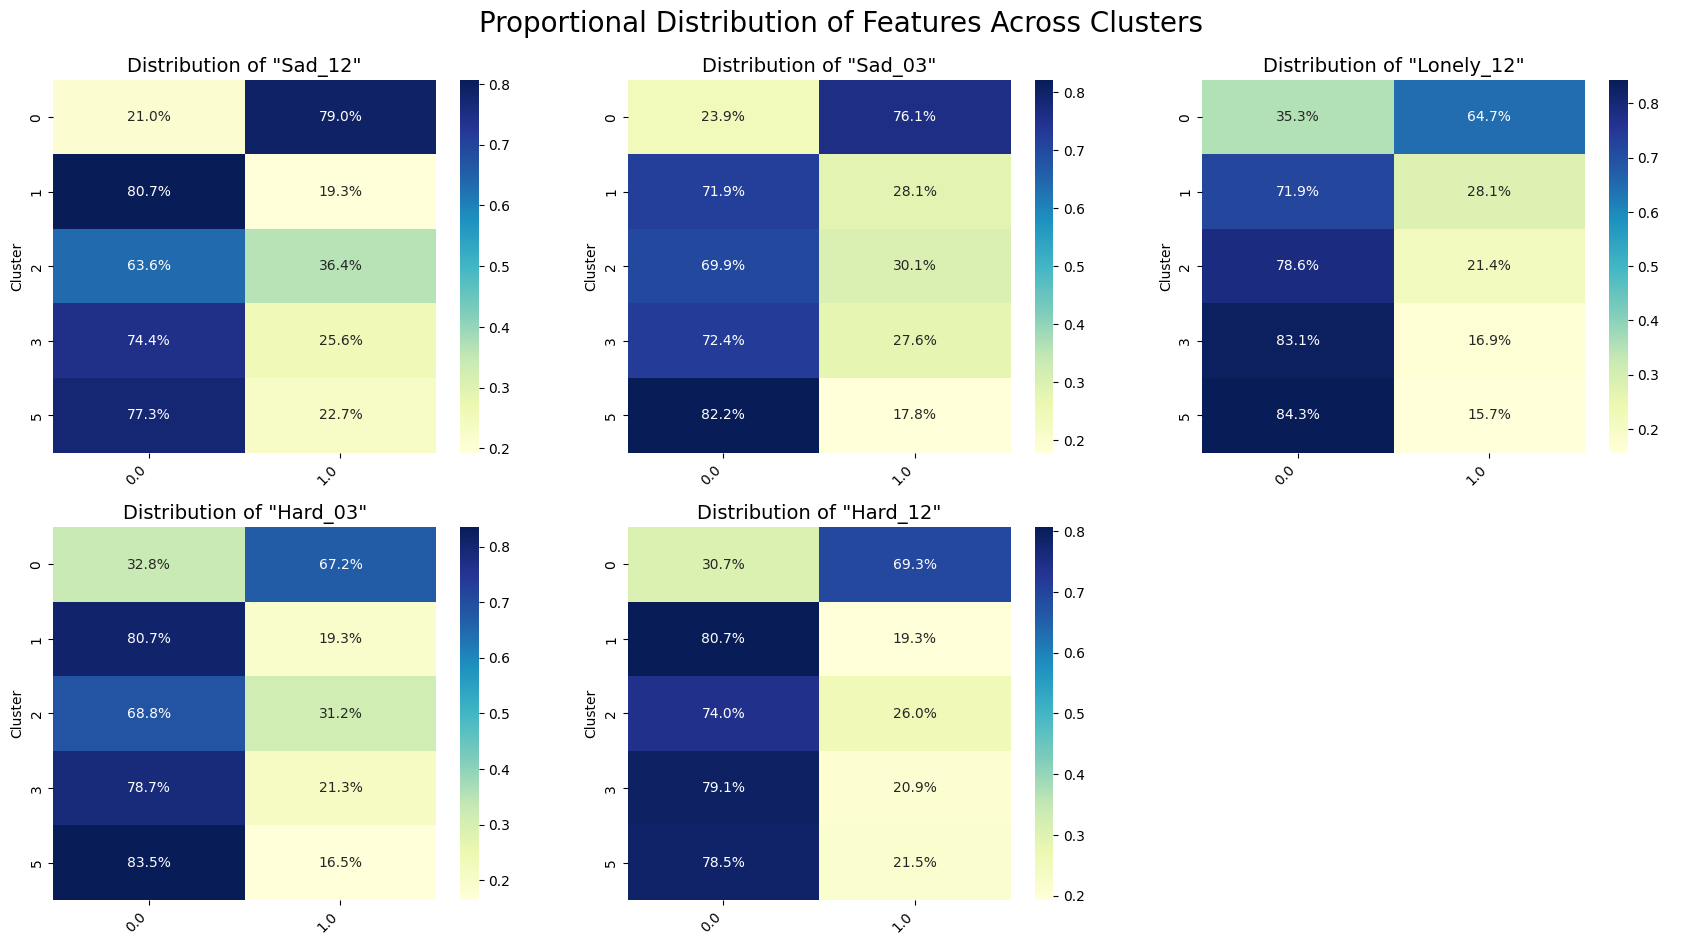

In [36]:
differentiating_features = top_differentiating_features[10:]

num_features = len(differentiating_features)

print("\n\n**********************************************")
print(f"--- Visualizing next {num_features} Differentiators... ---")
print("**********************************************")

# Check if the number of features is even or odd to set the number of columns
if num_features % 2 == 0:
    ncols = 2
else:
    ncols = 3

# Calculate the number of rows needed using ceiling division
nrows = math.ceil(num_features / ncols)

# Create a figure that's sized appropriately for the grid
# We make it wider for more columns and taller for more rows
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols * 7, nrows * 5) # Dynamic sizing
)

# Flatten the axes array to make it easy to loop through, even if it's just one row
flat_axes = axes.flatten()

# Loop through both the features and the corresponding axis object
for feature, ax in zip(differentiating_features, flat_axes):
    # Create the proportion table (same as before)
    proportion_df = pd.crosstab(index=df_analysis['cluster'], columns=df_analysis[feature], normalize='index')
    # Create the heatmap on the specific axis 'ax'
    sns.heatmap(
        proportion_df, 
        annot=True,
        cmap="YlGnBu",
        fmt=".1%",
        ax=ax
    )
    # Set the title and labels for the individual subplot
    ax.set_title(f'Distribution of "{feature}"', fontsize=14)
    ax.set_ylabel('Cluster')
    ax.set_xlabel('') # Keep the x-axis label clean

    # Rotate the x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# If we have an odd number of plots in an even grid, some axes will be empty.
# This loop turns them off to keep the figure clean.
for i in range(num_features, len(flat_axes)):
    flat_axes[i].axis('off')

# Add a main title for the entire figure
# Add a main title for the entire figure
fig.suptitle('Proportional Distribution of Features Across Clusters', fontsize=20, y=1.0) # Adjust y to give it space
# Use subplots_adjust for more control over spacing instead of tight_layout
fig.subplots_adjust(
    top=0.93,
    hspace=0.2,  # <-- Increase this value to add more vertical space
    wspace=0.2   # You can adjust this for horizontal space if needed
)
plt.show()

### Key Insights from the Heatmaps

1. A Clear Picture of Emotional Distress: These four plots, viewed together, paint an undeniable picture of the `mental` state that defines the clusters. The pattern is strikingly consistent across all of them.
2. `Cluster 0` is Defined by `Negative` Emotions: `Cluster 0 ("The Frail & Vulnerable")` is completely isolated from the others. In every single plot, a large majority of its members report experiencing `negative` feelings:
   - `79.0%` felt `Sad (Sad_12)`.
   - `64.7%` felt `Lonely (Lonely_12)`.
   - `67.2%` felt life was `Hard (Hard_03)`.

3. The dark blue color for the 1.0 (Yes) category is a constant visual signature for this group.
4. Other Clusters Show Strong Emotional Resilience: In stark contrast, all other `clusters (1, 2, 3, and 5)` show the `opposite pattern`. The vast majority of their members report `not feeling sad, lonely`, or `that life is hard`. The dark blue is consistently under the `0.0 (No) category` for these groups.
4. Confirmation of Personas: This analysis provides the final, crucial layer to your cluster personas. It confirms that `Cluster 0's physical frailty and low socioeconomic status` are accompanied by significant and persistent emotional and psychological distress, solidifying its identity as the most vulnerable group in the dataset.

### Final Summary Table: Personas of the Discovered Clusters
<hr>

This table consolidates the defining features for each meaningful cluster. The "Indicator Strength" reflects how strongly a feature's specific value distinguishes that cluster from the others.

| Cluster | Persona Name | Feature Domain | Feature Name | Defining Characteristic | Indicator Strength |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 0 | The Frail & Vulnerable | Numeric - Health & Frailty | Num_ADL_12, Num_IADL_12 | Highest rate of physical impairment (10-20x higher than others). | Very Strong |
| | | Categorical - Mental Health | Depressed, Sad, Lonely, Hard | Overwhelmingly reports Yes (approx. 65-80 percent) to all negative emotional states. | Very Strong |
| | | Numeric - Mental Health | Num_CES-D_Symptoms_12 | Highest number of depressive symptoms (approx. 2x higher than others). | Very Strong |
| | | Categorical - Lifestyle | Employment_12 | Predominantly "Dedicated to Household Chores" (approx. 47 percent). | Strong |
| | | Numeric - Health & Frailty | Num_Illnesses_03 | Highest number of chronic illnesses. | Strong |
| | | Categorical - Demographics | Gender | Predominantly "Woman" (approx. 81 percent). | Strong |
| 1 | The Ultra-Wealthy Elite | Numeric - Socioeconomic | hincome_03, hinc_business_03 | Extremely high income from business and capital (over 600k), orders of magnitude higher. | Very Strong |
| | | Categorical - Lifestyle | Employment_12 | Predominantly "Currently Working" (approx. 37 percent). | Strong |
| | | Categorical - Demographics | Gender | Balanced gender split (approx. 50/50). | Moderate |
| 2 | The Working Middle Cohort | Categorical - Lifestyle | Employment_12 | Predominantly "Currently Working" (approx. 34 percent). | Strong |
| | | Numeric - Socioeconomic | Earnings_03 | Higher personal earnings (approx. 11k) compared to Cluster 3. | Moderate |
| | | Categorical - Demographics | Gender | Slightly more "Woman" than "Man" (approx. 54 percent). | Moderate |
| 3 | The Non-Working Middle Cohort | Categorical - Demographics | Gender | Overwhelmingly "Woman" (approx. 90 percent). | Very Strong |
| | | Categorical - Lifestyle | Employment_12 | Overwhelmingly "Dedicated to Household Chores" (approx. 68 percent). | Very Strong |
| | | Numeric - Socioeconomic | SpouseEarnings_03, SpousePension_03| Higher spousal income and pension compared to Cluster 2. | Moderate |
| 5| The High-Earning Professionals| Categorical - Demographics | Gender | Overwhelmingly "Man" (approx. 86 percent), the only male-dominated group. | Very Strong |
| | | Numeric - Socioeconomic | Earnings_03, Pension_12 | Highest income from employment (approx. 32k) and pensions (approx. 27k). | Strong |
| | | Numeric - Health & Frailty | Num_Illnesses_03 | Lowest number of chronic illnesses; the healthiest group. | Strong |
| | | Categorical - Lifestyle | JobCatLongest_12 | Most diverse job background, with a unique high proportion in Agriculture/Forestry. | Moderate |

In [37]:
# df_processed_for_clustering

In [38]:
#print(df_processed_for_clustering.columns.tolist(), end='')

#### Save to .CSV

In [39]:
# --- Final Step: Save the Clustered Data ---

# We need to save this because the new notebook needs the 'cluster' column.
df.to_csv(path_train_new_clustered, index=False, encoding="utf8")

print(f"File saved successfully to: {path_train_new_clustered}")
print("You can now open the new notebook and load this file.")

File saved successfully to: ..\dataset\modified\train_with_clusters.csv
You can now open the new notebook and load this file.


### Find the most important columns for each cluster (an exploratory step).

-----------------------------------------------------------
------- Analyzing Feature Importances for Cluster 0 -------
-----------------------------------------------------------

>>> Top 10 NUMERIC Features for Cluster 0:
1. hincome_12 (Imp: 0.0368)
2. hincome_03 (Imp: 0.0222)
3. Num_Illnesses_03 (Imp: 0.0118)
4. Num_CES-D_Symptoms_12 (Imp: 0.0111)
5. Num_CES-D_Symptoms_03 (Imp: 0.0107)
6. SpouseEarnings_03 (Imp: 0.0106)
7. Num_Illnesses_12 (Imp: 0.0097)
8. JobHrsWeekly_03 (Imp: 0.0095)
9. Num_IADL_12 (Imp: 0.0085)
10. Pension_12 (Imp: 0.0083)




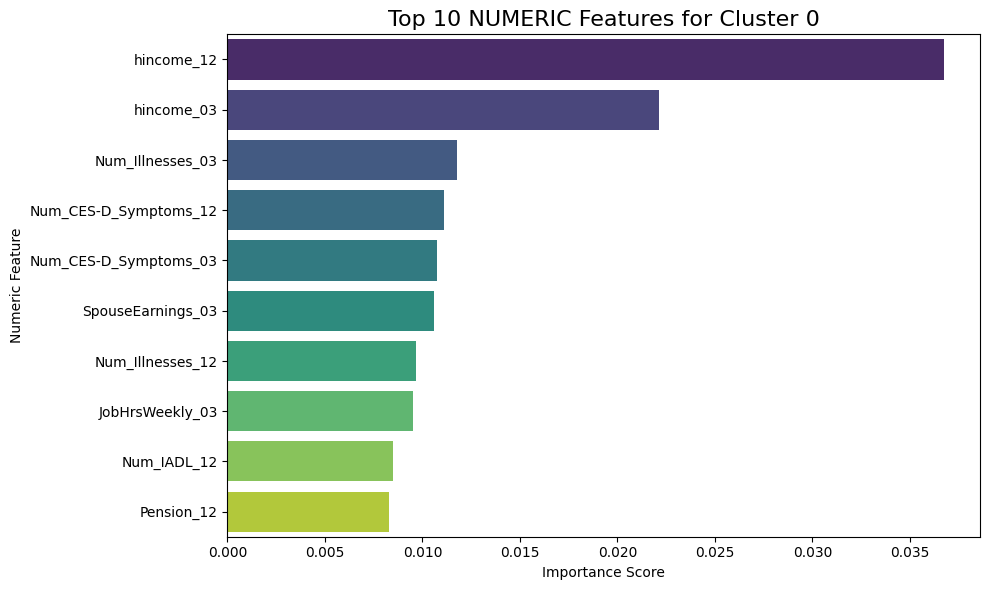


>>> Top 10 CATEGORICAL Features for Cluster 0:
1. Education_03_No education (Imp: 0.0849)
2. Education_12_No education (Imp: 0.0693)
3. CareChild_12_1.0 (Imp: 0.0371)
4. Age_12_80+ (Imp: 0.0356)
5. Year_2021 (Imp: 0.0231)
6. Age_12_70-79 (Imp: 0.0184)
7. Reads_12_1.0 (Imp: 0.0148)
8. Num_Living_Child_12_3 or 4 (Imp: 0.0132)
9. Meet_FnF_12_Never (Imp: 0.0122)
10. SocialActivities_12_Never (Imp: 0.0105)




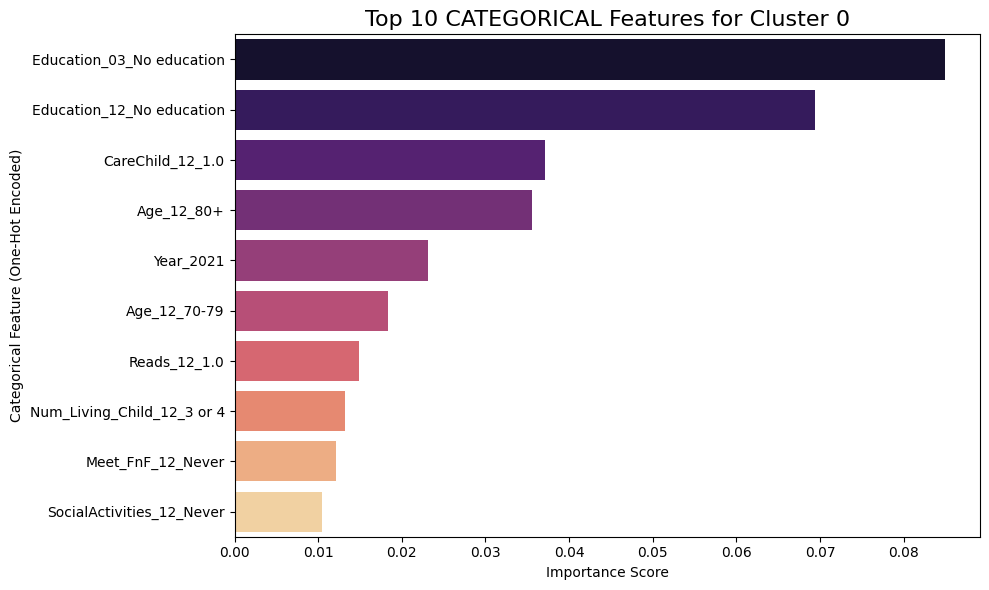

-----------------------------------------------------------
------- Analyzing Feature Importances for Cluster 1 -------
-----------------------------------------------------------

>>> Top 10 NUMERIC Features for Cluster 1:
1. hinc_cap_03 (Imp: 0.1320)
2. hinc_business_03 (Imp: 0.0327)
3. hincome_03 (Imp: 0.0193)
4. JobHrsWeekly_03 (Imp: 0.0155)
5. Num_IADL_03 (Imp: 0.0147)
6. hincome_12 (Imp: 0.0075)
7. JobHrsWeekly_12 (Imp: 0.0063)
8. Pension_12 (Imp: 0.0060)
9. Num_CES-D_Symptoms_03 (Imp: 0.0053)
10. hinc_rent_03 (Imp: 0.0047)




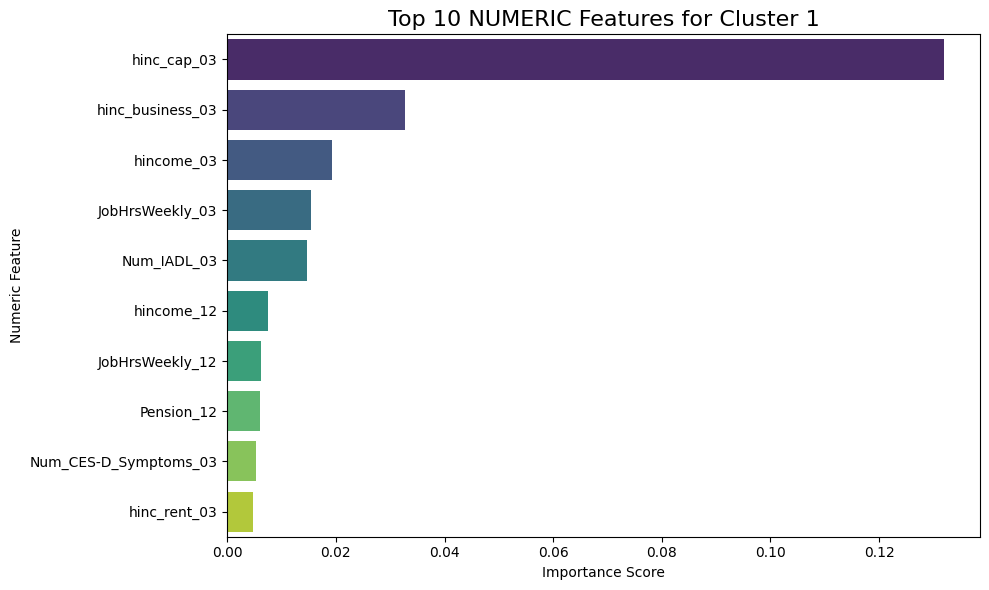


>>> Top 10 CATEGORICAL Features for Cluster 1:
1. Age_03_50-59 (Imp: 0.0553)
2. Visit_Dental_03_1.0 (Imp: 0.0543)
3. BMI_12_Over Weight (Imp: 0.0363)
4. UseElectronicDevices_12_1.0 (Imp: 0.0339)
5. Visit_Dental_12_1.0 (Imp: 0.0315)
6. Satement_Fine_12_Neither Agrees nor Disagrees (Imp: 0.0313)
7. Urban_03_Urban (Imp: 0.0291)
8. Age_03_60-69 (Imp: 0.0256)
9. Sad_12_1.0 (Imp: 0.0236)
10. Restless_12_1.0 (Imp: 0.0221)




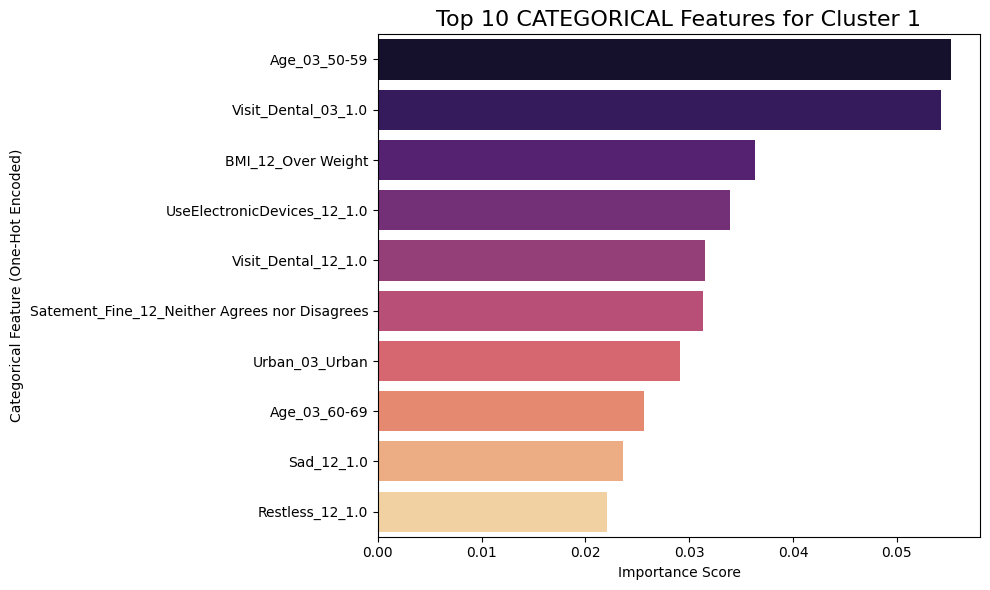

-----------------------------------------------------------
------- Analyzing Feature Importances for Cluster 2 -------
-----------------------------------------------------------

>>> Top 10 NUMERIC Features for Cluster 2:
1. hincome_03 (Imp: 0.1151)
2. Num_CES-D_Symptoms_03 (Imp: 0.0216)
3. hincome_12 (Imp: 0.0176)
4. JobHrsWeekly_12 (Imp: 0.0130)
5. JobHrsWeekly_03 (Imp: 0.0113)
6. Pension_12 (Imp: 0.0108)
7. SpouseEarnings_03 (Imp: 0.0088)
8. Num_CES-D_Symptoms_12 (Imp: 0.0077)
9. hinc_business_03 (Imp: 0.0067)
10. Marriages_12 (Imp: 0.0062)




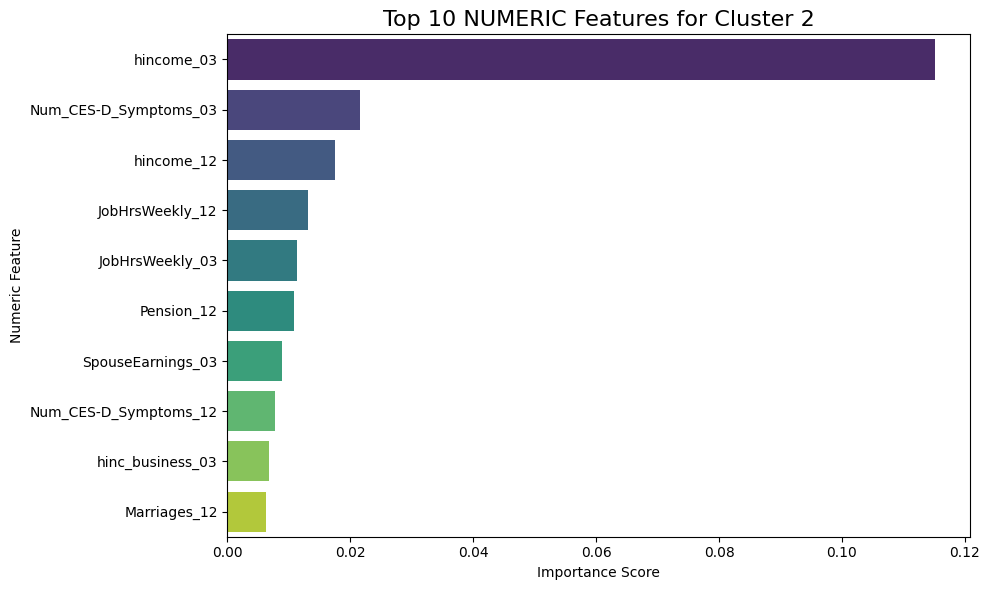


>>> Top 10 CATEGORICAL Features for Cluster 2:
1. Education_03_No education (Imp: 0.0882)
2. SocialActivities_12_Never (Imp: 0.0290)
3. Education_12_6 Years (Imp: 0.0215)
4. Age_03_70-79 (Imp: 0.0209)
5. Age_12_80+ (Imp: 0.0196)
6. Education_12_No education (Imp: 0.0190)
7. Age_03_50-59 (Imp: 0.0187)
8. Reads_12_1.0 (Imp: 0.0174)
9. Year_2021 (Imp: 0.0168)
10. Employment_12_Currently Working (Imp: 0.0153)




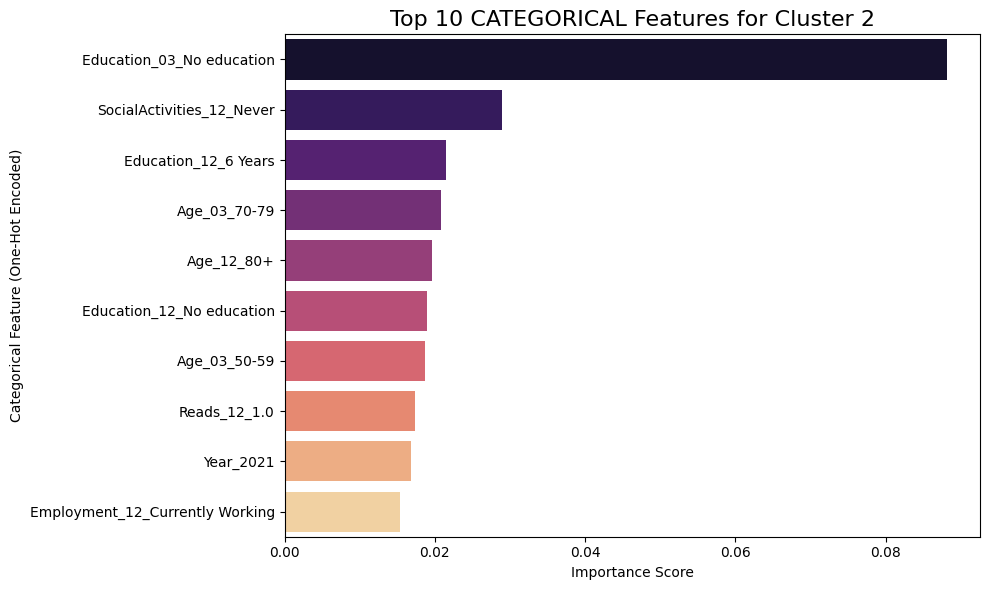

-----------------------------------------------------------
------- Analyzing Feature Importances for Cluster 3 -------
-----------------------------------------------------------

>>> Top 10 NUMERIC Features for Cluster 3:
1. hincome_03 (Imp: 0.0277)
2. hincome_12 (Imp: 0.0184)
3. Num_CES-D_Symptoms_03 (Imp: 0.0172)
4. Num_CES-D_Symptoms_12 (Imp: 0.0116)
5. JobHrsWeekly_03 (Imp: 0.0090)
6. SpousePension_03 (Imp: 0.0075)
7. SpouseEarnings_03 (Imp: 0.0074)
8. SpousePension_12 (Imp: 0.0074)
9. SpouseEarnings_12 (Imp: 0.0070)
10. Num_Illnesses_03 (Imp: 0.0069)




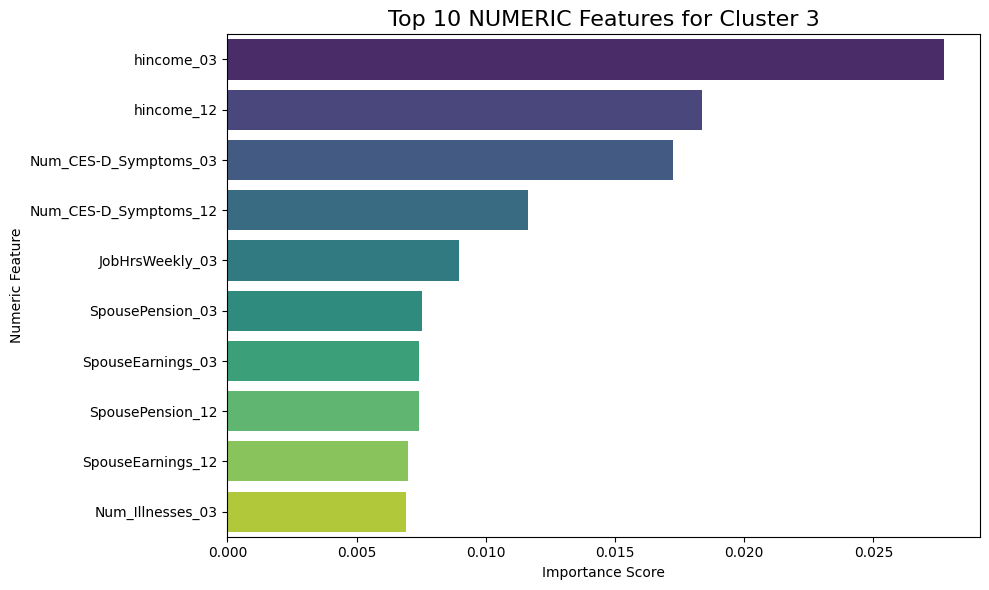


>>> Top 10 CATEGORICAL Features for Cluster 3:
1. Education_03_No education (Imp: 0.1839)
2. Education_03_10+ Years (Imp: 0.0674)
3. Education_03_7-9 Years (Imp: 0.0655)
4. Education_03_6 Years (Imp: 0.0259)
5. Year_2021 (Imp: 0.0184)
6. Age_03_70-79 (Imp: 0.0121)
7. Games_12_1.0 (Imp: 0.0103)
8. SocialActivities_12_Never (Imp: 0.0102)
9. Reads_12_1.0 (Imp: 0.0095)
10. Age_03_60-69 (Imp: 0.0093)




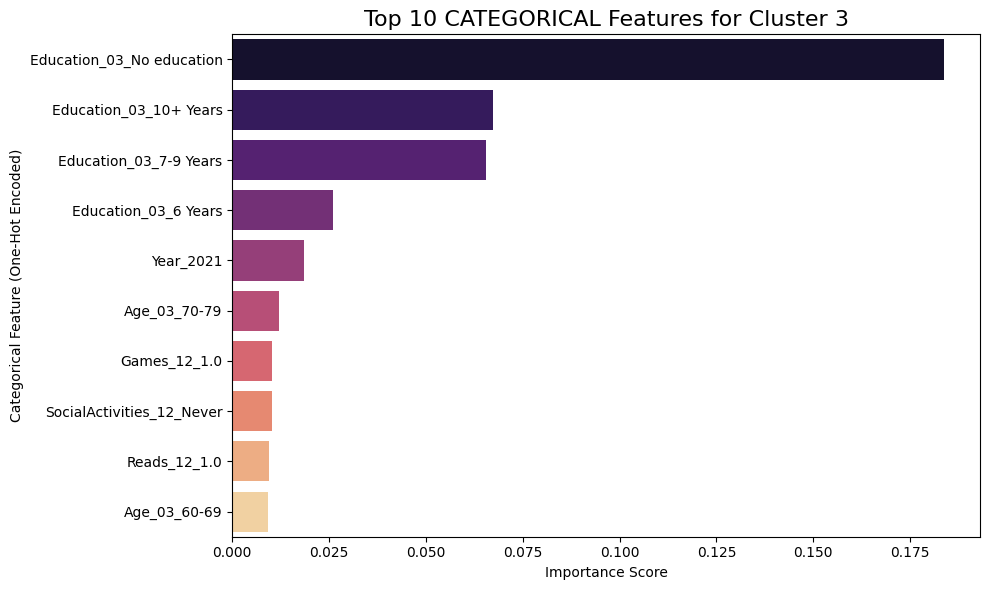

-----------------------------------------------------------
------- Analyzing Feature Importances for Cluster 5 -------
-----------------------------------------------------------

>>> Top 10 NUMERIC Features for Cluster 5:
1. JobHrsWeekly_03 (Imp: 0.0261)
2. hincome_03 (Imp: 0.0217)
3. Earnings_03 (Imp: 0.0207)
4. hincome_12 (Imp: 0.0154)
5. JobHrsWeekly_12 (Imp: 0.0135)
6. Num_CES-D_Symptoms_03 (Imp: 0.0083)
7. Num_CES-D_Symptoms_12 (Imp: 0.0073)
8. Pension_12 (Imp: 0.0060)
9. Num_Illnesses_12 (Imp: 0.0053)
10. Pension_03 (Imp: 0.0049)




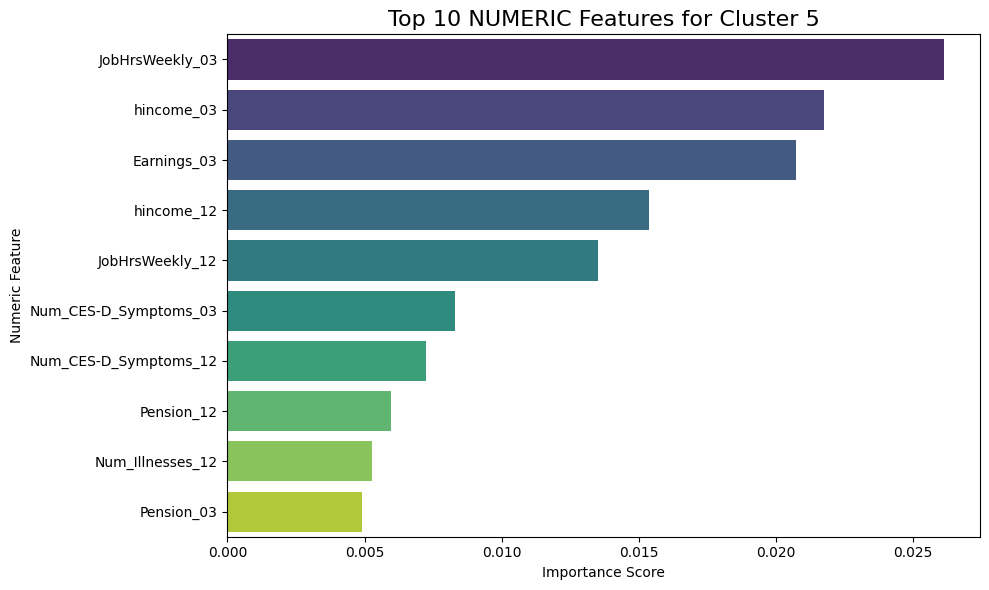


>>> Top 10 CATEGORICAL Features for Cluster 5:
1. Education_03_10+ Years (Imp: 0.2594)
2. Education_03_7-9 Years (Imp: 0.0660)
3. Education_12_7-9 Years (Imp: 0.0648)
4. Education_03_6 Years (Imp: 0.0598)
5. Education_03_No education (Imp: 0.0202)
6. Year_2021 (Imp: 0.0134)
7. Education_12_No education (Imp: 0.0131)
8. Education_12_6 Years (Imp: 0.0110)
9. BMI_03_Under Weight (Imp: 0.0101)
10. Age_12_60-69 (Imp: 0.0089)




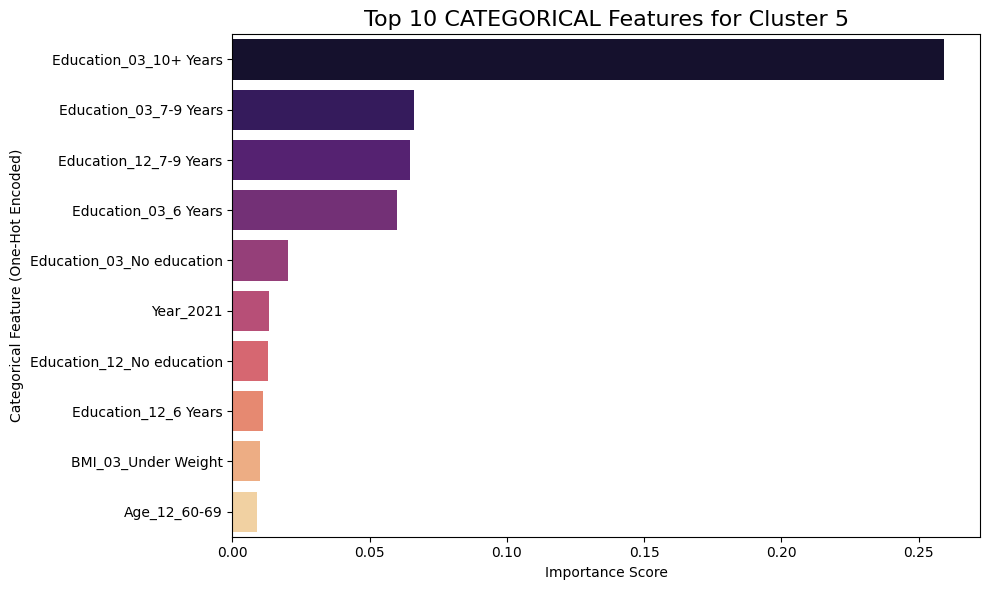

In [40]:
# --- Loop, Train, and Plot ---

# Use your main DataFrame that now has the 'cluster' column and your fully processed DataFrame for modeling. Let's align them to be safe.
df_aligned = df.loc[df_processed_for_clustering.index]

# Define your target and features The features (X) must come from the processed (scaled/encoded) data
X_processed = df_processed_for_clustering
y = df_aligned['composite_score']

# List of clusters to analyze (skipping cluster 4 as it only has 1 member)
clusters_to_analyze = [0, 1, 2, 3, 5]

# --- Loop, Train, and Plot ---
for cluster_id in clusters_to_analyze:
    print("-" * 59)
    print(f"------- Analyzing Feature Importances for Cluster {cluster_id} -------")
    print("-" * 59)

    # 1. Filter the data for the current cluster
    cluster_indices = df_aligned[df_aligned['cluster'] == cluster_id].index
    X_cluster = X_processed.loc[cluster_indices]
    y_cluster = y.loc[cluster_indices]

    if len(X_cluster) < 50:
        print(f"Cluster {cluster_id} is too small. Skipping.\n")
        continue

    # 2. Train the model on ALL features
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_cluster, y_cluster)

    # 3. Get the full list of feature importances
    importances = model.feature_importances_
    
    # This DataFrame contains importances for ALL features (numeric and categorical)
    full_importance_df = pd.DataFrame({
        'feature': X_cluster.columns,
        'importance': importances
    })

    # --- PART A: Numeric Features Analysis ---
    # Filter: Keep only features present in 'cols_numeric'
    numeric_importance_df = full_importance_df[
        full_importance_df['feature'].isin(cols_numeric)
    ].sort_values('importance', ascending=False).head(10)

    # *** PRINTING NUMERIC FEATURES ***
    print(f"\n>>> Top 10 NUMERIC Features for Cluster {cluster_id}:")
    for i, (index, row) in enumerate(numeric_importance_df.iterrows(), 1):
        print(f"{i}. {row['feature']} (Imp: {row['importance']:.4f})")
    print("\n") # Add space before plot

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=numeric_importance_df, palette='viridis', hue='feature', legend=False)
    plt.title(f'Top 10 NUMERIC Features for Cluster {cluster_id}', fontsize=16)
    plt.xlabel('Importance Score')
    plt.ylabel('Numeric Feature')
    plt.tight_layout()
    plt.show()

    # --- PART B: Categorical Features Analysis ---
    # Filter: Keep features NOT in 'cols_numeric' (The ~ symbol means "NOT")
    categorical_importance_df = full_importance_df[
        ~full_importance_df['feature'].isin(cols_numeric)
    ].sort_values('importance', ascending=False).head(10)

    # *** PRINTING CATEGORICAL FEATURES ***
    print(f"\n>>> Top 10 CATEGORICAL Features for Cluster {cluster_id}:")
    for i, (index, row) in enumerate(categorical_importance_df.iterrows(), 1):
        print(f"{i}. {row['feature']} (Imp: {row['importance']:.4f})")
    print("\n") # Add space before plot

    plt.figure(figsize=(10, 6))
    # Using a different color palette (magma) to distinguish from numeric plots
    sns.barplot(x='importance', y='feature', data=categorical_importance_df, palette='magma', hue='feature', legend=False)
    plt.title(f'Top 10 CATEGORICAL Features for Cluster {cluster_id}', fontsize=16)
    plt.xlabel('Importance Score')
    plt.ylabel('Categorical Feature (One-Hot Encoded)')
    plt.tight_layout()
    plt.show()  
    

**This is a critical insight and it confirms two things:**

The 'Year' column was definitely included in data (it was One-Hot Encoded into Year_2016 and Year_2021).

There is a "Time Effect" in the data. The fact that `Year_2021` helps predict the score in almost every cluster suggests that the composite_score was systematically different in `2021` compared to `2016` (likely lower or higher across the board, perhaps due to sampling differences or external factors like COVID-19).

**Why is it missing from Cluster 1 ("The Ultra-Wealthy")?**

This is the most fascinating part. It suggests that `Wealth` is a `"Buffer"`.

For the Ultra-Wealthy, their massive assets `(hincome_03 ~600k)` are such a dominant predictor of their high cognitive scores that the year they were interviewed doesn't matter. Their wealth protects them from the `"Time Effect"` that impacts the Frail (Cluster 0) and the Middle Class (Clusters 2, 3, 5).

**Is this a problem?**

Yes, for a Predictive Model.

If you want to use this model in the future (e.g., 2026), a feature like `Year_2021` is useless. The model is `"cheating"` by using the survey date to guess the score, rather than relying purely on the patient's `health` or `demographics`.

**Recommended Fix (in your new file)**

It is not necessarily needed to re-do the clustering (since the groups seem robust), but we should remove the `Year` columns before training our final predictive models. This forces the model to learn the actual reasons for the score (like Health, Jobs, Depression) rather than just the date.


### Train a separate, specialist model for each cluster (a predictive step). continued in other notebook

In [41]:
# new_person_data -> scaler.transform() -> kmeans.predict() -> cluster_id
# For each cluster:
# data_cluster = df[df['cluster'] == cluster_id]
# predictor_cluster = TabularPredictor(...).fit(data_cluster)
# predictor_cluster.save() # Save this specialist model